In [1]:
import numpy as np
import matplotlib.pyplot as plt

#for GP
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, DotProduct

In [2]:
from UserClass import *
from basic_environments import *
from basic_learners import *

In [3]:
%run DATA_users.py
%run DATA_parameters.py

In [4]:
user_classes = [C1, C2, C3]
real_contexts = [[(uc.F1, uc.F2)] for uc in user_classes ]

### Environment

In [5]:
class ContextEnvironment:
    def __init__(self, bids, prices, sigma_clicks, sigma_costs, margin_param, userclass):

        self.bidding_environment = BiddingEnvironment(bids, sigma_clicks, sigma_costs, userclass)
        self.pricing_environment = PricingEnvironment(prices, margin_param, userclass)


    def round(self, pulled_arm_bid, pulled_arm_price):
        n_daily_clicks, cum_daily_costs = self.bidding_environment.round(pulled_arm_bid)
        converted_clicks, reward = self.pricing_environment.round_step3(pulled_arm_price, n_daily_clicks, cum_daily_costs)

        return n_daily_clicks, cum_daily_costs, converted_clicks, reward

In [7]:
class Environment:
    def __init__(self, bids, prices, sigma_clicks, sigma_costs, margin_param, user_classes):
        self.user_classes = user_classes
        self.n_classes = len(user_classes)
        self.user_environments = [ContextEnvironment(bids, prices, sigma_clicks, sigma_costs, margin_param, user_class) for user_class in user_classes]
        self.features_list = [(user_class.F1,user_class.F2) for user_class in user_classes]
        
        
    def round(self, pulled_arm_bid_list, pulled_arm_price_list, pulled_contexts):
        
        n_daily_clicks_list = []
        cum_daily_costs_list = []
        converted_clicks_list = []
        reward_list = []
        for user, user_env in zip(self.user_classes, self.user_environments):
            for pulled_arm_bid, pulled_arm_price, context in zip(pulled_arm_bid_list, pulled_arm_price_list, pulled_contexts):
                n_daily_clicks, cum_daily_costs, converted_clicks, reward = user_env.round(pulled_arm_bid, pulled_arm_price)

                
                if (user.F1,user.F2) in context:
                    n_daily_clicks_list.append(n_daily_clicks)
                    cum_daily_costs_list.append(cum_daily_costs)
                    converted_clicks_list.append(converted_clicks)
                    reward_list.append(reward)
                    break
            
        return n_daily_clicks_list, cum_daily_costs_list, converted_clicks_list, reward_list, self.features_list

## Learners

hp:
- we assume that the features we observe are binary  
    e.g. if we have 2 features: (0,0), (0,1), (1,0), (1,1) are the all the possible observations

### UCB

In [8]:
class UCB_SingleContextLearner(Learner):
    def __init__(self, arms_bids, arms_prices, margin_param, context, M = 1):
        n_arms_bids = len(arms_bids)
        n_arms_prices = len(arms_prices)
        super().__init__(0)
        self.rewards_per_arm = [[[] for i in range(n_arms_prices)] for j in range(n_arms_bids)] 

        self.arms_prices = arms_prices
        self.arms_bids = arms_bids

        self.margin_param = margin_param

        #learners:
        self.n_daily_clicks_learner = GPUCB_Learner(arms_bids)
        self.cum_daily_costs_learner = GPUCB_Learner(arms_bids)
        self.expected_margin_learner = UCB1_Learner(n_arms_prices, (0,M))

        self.context = context


    def pull_arm(self):
        ub_clicks = self.n_daily_clicks_learner.means + self.n_daily_clicks_learner.sigmas
        lb_costs = self.cum_daily_costs_learner.means - self.cum_daily_costs_learner.sigmas
        ub_expected_margin = self.expected_margin_learner.empirical_means + self.expected_margin_learner.confidence

        idx_price_arm = np.random.choice(np.where(ub_expected_margin == ub_expected_margin.max())[0])

        ub_reward = ub_clicks * ub_expected_margin[idx_price_arm] - lb_costs
        idx_bid_arm = np.random.choice(np.where(ub_reward == ub_reward.max())[0])

        return (idx_bid_arm, idx_price_arm)
    

    def update_observations(self, pulled_arm_bid, pulled_arm_price, reward):
        self.rewards_per_arm[pulled_arm_bid][pulled_arm_price].append(reward)
        self.collected_rewards.append(reward)


    def update(self, pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, converted_clicks, reward):
        
        self.t += 1
        self.update_observations(pulled_arm_bid, pulled_arm_price, reward)

        self.n_daily_clicks_learner.update(pulled_arm_bid, n_daily_clicks)
        self.cum_daily_costs_learner.update(pulled_arm_bid, cum_daily_costs)

        if n_daily_clicks > 0:
            expected_margin = (converted_clicks / n_daily_clicks) * (self.arms_prices[pulled_arm_price] - self.margin_param)
            self.expected_margin_learner.update(pulled_arm_price, expected_margin)
        else:
            self.expected_margin_learner.t += 1

    
    def update_from_batch(self, pulled_arm_bid_data, pulled_arm_price_data, n_daily_clicks_data, cum_daily_costs_data, converted_clicks_data, reward_data, time):
        arms_of_alphas = []
        alphas = []
        for i, reward in enumerate(reward_data):
            self.update_observations(pulled_arm_bid_data[i], pulled_arm_price_data[i], reward)
            if n_daily_clicks_data[i] > 0:
                arms_of_alphas.append(pulled_arm_price_data[i])
                alphas.append((converted_clicks_data[i] / n_daily_clicks_data[i]) * (self.arms_prices[pulled_arm_price_data[i]] - self.margin_param))

        self.expected_margin_learner.update_from_batch(arms_of_alphas, alphas, time)
        self.n_daily_clicks_learner.update_from_batch(pulled_arm_bid_data, n_daily_clicks_data, time)
        self.cum_daily_costs_learner.update_from_batch(pulled_arm_bid_data, cum_daily_costs_data, time)
        self.t += time


In [9]:
class UCB_FixedContextsLearner(Learner):
    def __init__(self, arms_bids, arms_prices, margin_param, contexts, M = 1):
        super().__init__(0)

        self.collected_n_daily_clicks = []
        self.collected_cum_daily_costs = []
        self.collected_converted_clicks = []
        self.collected_features = []

        self.n_arms_bids = len(arms_bids)
        self.n_arms_prices = len(arms_prices)
        self.arms_prices = arms_prices
        self.arms_bids = arms_bids

        self.margin_param = margin_param
        self.contexts = contexts
        
        self.M = M 
        # Learners:
        self.context_learners = [UCB_SingleContextLearner(arms_bids, arms_prices, margin_param, context, M) for context in self.contexts]


    def pull_arm(self):
        idx_bid_arm_list = []
        idx_price_arm_list = []
        for context_learner in self.context_learners:
            idx_bid_arm, idx_price_arm = context_learner.pull_arm()
            idx_bid_arm_list.append(idx_bid_arm)
            idx_price_arm_list.append(idx_price_arm)

        return (idx_bid_arm_list, idx_price_arm_list, self.contexts)


    def update_observations(self, n_daily_clicks_list, cum_daily_costs_list, converted_clicks_list, reward_list, features_list):
        self.collected_rewards.append(reward_list)
        self.collected_n_daily_clicks.append(n_daily_clicks_list)
        self.collected_cum_daily_costs.append(cum_daily_costs_list)
        self.collected_converted_clicks.append(converted_clicks_list)
        self.collected_features.append(features_list)
        

    def update(self, pulled_arm_bid_list, pulled_arm_price_list,
               n_daily_clicks_list, cum_daily_costs_list, converted_clicks_list, reward_list, features_list):
        self.t += 1
        self.update_observations(n_daily_clicks_list, cum_daily_costs_list, converted_clicks_list, reward_list, features_list)

        for i,context in enumerate(self.contexts):
            pulled_arm_bid_data = []
            pulled_arm_price_data = []

            n_daily_clicks_data = []
            cum_daily_costs_data = []
            converted_clicks_data = []
            reward_data = []

            for j,fts in enumerate(features_list):
                if fts in context:
                    pulled_arm_bid_data.append(pulled_arm_bid_list[i])
                    pulled_arm_price_data.append(pulled_arm_price_list[i])

                    n_daily_clicks_data.append(n_daily_clicks_list[j])
                    cum_daily_costs_data.append(cum_daily_costs_list[j])
                    converted_clicks_data.append(converted_clicks_list[j])
                    reward_data.append(reward_list[j])

            self.context_learners[i].update_from_batch(pulled_arm_bid_data, pulled_arm_price_data,
                                                       n_daily_clicks_data, cum_daily_costs_data, converted_clicks_data, reward_data, 1)

In [10]:
class UCB_ContextsGreadyLearner(UCB_FixedContextsLearner):
    def __init__(self, arms_bids, arms_prices, margin_param, window_context, M = 1): 
        contexts = [ [(0,0),(0,1),(1,0),(1,1)] ] 
        super().__init__(arms_bids, arms_prices, margin_param, contexts, M = M)

        self.window_context = window_context

        self.collected_pulled_arm_bid = []
        self.collected_pulled_arm_price = []


    def collect_pulled_arms(self, pulled_arm_bid_list, pulled_arm_price_list, features_list):
        idx_bid_list = []
        idx_price_list =  []

        for fts in features_list:
            for j,context in enumerate(self.contexts):
                if fts in context:
                    idx_bid_list.append(pulled_arm_bid_list[j])
                    idx_price_list.append(pulled_arm_price_list[j])
                    break

        self.collected_pulled_arm_bid.append(idx_bid_list)
        self.collected_pulled_arm_price.append(idx_price_list)


    def get_total_lb_from_contexts(self, context_learners):
        lb_reward_tot = 0
        for context_learner in context_learners:
            lb_clicks = min(context_learner.n_daily_clicks_learner.means - context_learner.n_daily_clicks_learner.sigmas)
            lb_convertion_rate = min(context_learner.conversion_rate_learner.empirical_means - context_learner.conversion_rate_learner.confidence)
            ub_costs = max(context_learner.cum_daily_costs_learner.means + context_learner.cum_daily_costs_learner.sigmas)

            lb_reward = lb_clicks * lb_convertion_rate * self.margin - ub_costs
            lb_reward_tot += lb_reward
        return lb_reward_tot


    def get_total_lb_from_contexts(self, context_learners):
        lb_reward_tot = 0
        for context_learner in context_learners:            
            idx_bid_arm, idx_price_arm = context_learner.pull_arm()
            
            lb_clicks = context_learner.n_daily_clicks_learner.means[idx_bid_arm] - 1.65 * context_learner.n_daily_clicks_learner.sigmas[idx_bid_arm]
            
            dim_setdata = len(context_learner.expected_margin_learner.rewards_per_arm[idx_price_arm])
            expected_margin_hat = context_learner.expected_margin_learner.empirical_means[idx_price_arm]
            lb_convertion_rate = expected_margin_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata))
            
            ub_costs = context_learner.cum_daily_costs_learner.means[idx_bid_arm] + 1.65 * context_learner.cum_daily_costs_learner.sigmas[idx_bid_arm]
            

            lb_reward = lb_clicks * lb_convertion_rate * (self.arms_prices[idx_price_arm] - self.margin_param) - ub_costs
            lb_reward_tot += lb_reward
        return lb_reward_tot


    def generate_partitions(self):
        """Greedy approach:
        returns a list of the partitions to be evaluated
        """
        partitions_list = []
        if len(self.contexts) == 1:
            partitions_list = [ [[(0,0),(0,1)], [(1,0),(1,1)]], [[(0,0),(1,0)], [(0,1),(1,1)]] ]
        if len(self.contexts) == 2:
            partitions_list = [ [[(0,0)], [(0,1)], [(1,0)], [(1,1)]] ]
        if len(self.contexts) == 4:
            partitions_list = []

        return partitions_list


    def update(self, pulled_arm_bid_list, pulled_arm_price_list,
               n_daily_clicks_list, cum_daily_costs_list, converted_clicks_list, reward_list, features_list):

        super().update(pulled_arm_bid_list, pulled_arm_price_list, n_daily_clicks_list, cum_daily_costs_list, converted_clicks_list, reward_list, features_list)
        self.collect_pulled_arms(pulled_arm_bid_list, pulled_arm_price_list, features_list)

        if self.t % self.window_context == 0: 
            print("evaluating change at time", self.t)
            lb_reward_current_partition = self.get_total_lb_from_contexts(self.context_learners)
            partitions_to_evaluate = self.generate_partitions()

            for partition in partitions_to_evaluate:
                new_context_learners = [UCB_SingleContextLearner(self.arms_bids, self.arms_prices, self.margin_param, context, self.M) for context in partition]

                for i,context in enumerate(partition):
                    pulled_arm_bid_data = []
                    pulled_arm_price_data = []
                    n_daily_clicks_data = []
                    cum_daily_costs_data = []
                    converted_clicks_data = []
                    reward_data = []
                    for t, collected_features_t in enumerate(self.collected_features):
                        for j, fts in enumerate(collected_features_t):
                            if fts in context:
                                pulled_arm_bid_data.append(self.collected_pulled_arm_bid[t][j])
                                pulled_arm_price_data.append(self.collected_pulled_arm_price[t][j])

                                n_daily_clicks_data.append(self.collected_n_daily_clicks[t][j])
                                cum_daily_costs_data.append(self.collected_cum_daily_costs[t][j])
                                converted_clicks_data.append(self.collected_converted_clicks[t][j])
                                reward_data.append(self.collected_rewards[t][j])

                    new_context_learners[i].update_from_batch(pulled_arm_bid_data, pulled_arm_price_data,
                                                              n_daily_clicks_data, cum_daily_costs_data, converted_clicks_data, reward_data, self.t)
                                                              
                ## evaluate lower bound of the new partition
                lb_reward_new_partition = self.get_total_lb_from_contexts(new_context_learners)
                print("  current lb reward = ", lb_reward_current_partition)
                print("  candidate partition lb reward = ", lb_reward_new_partition)

                # Now we need to compare this lb with the lb of the current partition to choose which is better
                if lb_reward_new_partition > lb_reward_current_partition:
                    self.contexts = partition.copy()
                    self.context_learners = new_context_learners
                    lb_reward_current_partition = lb_reward_new_partition

                    print(f'PARTITION CHANGED AT TIME {self.t}')

### TS

In [11]:
class TS_SingleContextLearner(Learner):
    def __init__(self, arms_bids, arms_prices, margin_param, context):
        n_arms_bids = len(arms_bids)
        n_arms_prices = len(arms_prices)
        
        super().__init__(0)
        self.rewards_per_arm = [[[] for i in range(n_arms_prices)] for j in range(n_arms_bids)]

        self.arms_prices = arms_prices
        self.arms_bids = arms_bids
        
        self.margin_param = margin_param

        #learners
        self.n_daily_clicks_learner = GPTS_Learner(arms_bids)
        self.cum_daily_costs_learner = GPTS_Learner(arms_bids)
        self.conversion_rate_learner = Binomial_TS_Learner(n_arms_prices)

        self.context = context

    def pull_arm(self):
        sampled_conversion_rates = np.random.beta( self.conversion_rate_learner.beta_parameters[:,0], self.conversion_rate_learner.beta_parameters[:,1] )
        sampled_clicks = np.random.normal(self.n_daily_clicks_learner.means, self.n_daily_clicks_learner.sigmas)
        sampled_costs = np.random.normal(self.cum_daily_costs_learner.means, self.cum_daily_costs_learner.sigmas)
        
        idx_price_arm = np.argmax(sampled_conversion_rates * (self.arms_prices - self.margin_param))

        idx_bid_arm = np.argmax(
            sampled_clicks * sampled_conversion_rates[idx_price_arm] * (self.arms_prices[idx_price_arm] - self.margin_param) - sampled_costs
            )
        
        return idx_bid_arm, idx_price_arm
    
    
    def update_observations(self, pulled_arm_bid, pulled_arm_price, reward):
        self.rewards_per_arm[pulled_arm_bid][pulled_arm_price].append(reward)
        self.collected_rewards.append(reward)
        

    def update(self, pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, converted_clicks, reward):
        
        self.t += 1
        self.update_observations(pulled_arm_bid, pulled_arm_price, reward)

        self.n_daily_clicks_learner.update(pulled_arm_bid, n_daily_clicks)
        self.cum_daily_costs_learner.update(pulled_arm_bid, cum_daily_costs)

        if n_daily_clicks > 0:
            self.conversion_rate_learner.update(pulled_arm_price, converted_clicks, n_daily_clicks)
        else:
            self.conversion_rate_learner.t += 1
            

    def update_from_batch(self, pulled_arm_bid_data, pulled_arm_price_data, n_daily_clicks_data, cum_daily_costs_data, converted_clicks_data, reward_data, time):

        arms_data = []
        k_data = []
        k_max_data = []
        for i, reward in enumerate(reward_data):
            self.update_observations(pulled_arm_bid_data[i], pulled_arm_price_data[i], reward)
            if n_daily_clicks_data[i] > 0:
                arms_data.append(pulled_arm_price_data[i])
                k_data.append(converted_clicks_data[i])
                k_max_data.append(n_daily_clicks_data[i])

        self.conversion_rate_learner.update_from_batch(arms_data, k_data, k_max_data, time)
        self.n_daily_clicks_learner.update_from_batch(pulled_arm_bid_data, n_daily_clicks_data, time)
        self.cum_daily_costs_learner.update_from_batch(pulled_arm_bid_data, cum_daily_costs_data, time)
        self.t += time

In [12]:
class TS_FixedContextsLearner(Learner):
    def __init__(self, arms_bids, arms_prices, margin_param, contexts):
        super().__init__(0)

        self.collected_n_daily_clicks = []
        self.collected_cum_daily_costs = []
        self.collected_converted_clicks = []
        self.collected_features = []

        self.n_arms_bids = len(arms_bids)
        self.n_arms_prices = len(arms_prices)
        self.arms_prices = arms_prices
        self.arms_bids = arms_bids

        self.margin_param = margin_param
        self.contexts = contexts

        # Learners:
        self.context_learners = [TS_SingleContextLearner(arms_bids, arms_prices, margin_param, context) for context in self.contexts]


    def pull_arm(self):
        idx_bid_arm_list = []
        idx_price_arm_list = []
        for context_learner in self.context_learners:
            idx_bid_arm, idx_price_arm = context_learner.pull_arm()
            idx_bid_arm_list.append(idx_bid_arm)
            idx_price_arm_list.append(idx_price_arm)

        return idx_bid_arm_list, idx_price_arm_list, self.contexts


    def update_observations(self, n_daily_clicks_list, cum_daily_costs_list, converted_clicks_list, reward_list, features_list):
        self.collected_rewards.append(reward_list)
        self.collected_n_daily_clicks.append(n_daily_clicks_list)
        self.collected_cum_daily_costs.append(cum_daily_costs_list)
        self.collected_converted_clicks.append(converted_clicks_list)
        self.collected_features.append(features_list)
        

    def update(self, pulled_arm_bid_list, pulled_arm_price_list,
               n_daily_clicks_list, cum_daily_costs_list, converted_clicks_list, reward_list, features_list):
        self.t += 1
        self.update_observations(n_daily_clicks_list, cum_daily_costs_list, converted_clicks_list, reward_list, features_list)

        for i,context in enumerate(self.contexts):
            pulled_arm_bid_data = []
            pulled_arm_price_data = []

            n_daily_clicks_data = []
            cum_daily_costs_data = []
            converted_clicks_data = []
            reward_data = []
            for j,fts in enumerate(features_list):
                if fts in context:
                    pulled_arm_bid_data.append(pulled_arm_bid_list[i])
                    pulled_arm_price_data.append(pulled_arm_price_list[i])

                    n_daily_clicks_data.append(n_daily_clicks_list[j])
                    cum_daily_costs_data.append(cum_daily_costs_list[j])
                    converted_clicks_data.append(converted_clicks_list[j])
                    reward_data.append(reward_list[j])

            self.context_learners[i].update_from_batch(pulled_arm_bid_data, pulled_arm_price_data,
                                                       n_daily_clicks_data, cum_daily_costs_data, converted_clicks_data, reward_data, 1)

In [13]:
class TS_ContextsGreedyLearner(TS_FixedContextsLearner):
    def __init__(self, arms_bids, arms_prices, margin_param, window_context):
        contexts = [ [(0,0),(0,1),(1,0),(1,1)] ] 
        super().__init__(arms_bids, arms_prices, margin_param, contexts)

        self.window_context = window_context

        self.collected_pulled_arm_bid = []
        self.collected_pulled_arm_price = []


    def collect_pulled_arms(self, pulled_arm_bid_list, pulled_arm_price_list, features_list):
        idx_bid_list = []
        idx_price_list =  []

        for fts in features_list:
            for j,context in enumerate(self.contexts):
                if fts in context:
                    idx_bid_list.append(pulled_arm_bid_list[j])
                    idx_price_list.append(pulled_arm_price_list[j])
                    break

        self.collected_pulled_arm_bid.append(idx_bid_list)
        self.collected_pulled_arm_price.append(idx_price_list)


    def get_total_lb_from_contexts(self, context_learners):
        lb_reward_tot = 0
        for context_learner in context_learners:
            idx_bid_arm, idx_price_arm = context_learner.pull_arm()
            
            lb_clicks = context_learner.n_daily_clicks_learner.means[idx_bid_arm] - 1.65 * context_learner.n_daily_clicks_learner.sigmas[idx_bid_arm]
            
            dim_setdata_cr = (context_learner.conversion_rate_learner.beta_parameters[idx_price_arm,0] + context_learner.conversion_rate_learner.beta_parameters[idx_price_arm,1])
            convertion_rate_hat = context_learner.conversion_rate_learner.beta_parameters[idx_price_arm,0] / dim_setdata_cr
            lb_convertion_rate = convertion_rate_hat - np.sqrt(-np.log(0.95)/(2 * dim_setdata_cr))
            
            ub_costs = context_learner.cum_daily_costs_learner.means[idx_bid_arm] + 1.65 * context_learner.cum_daily_costs_learner.sigmas[idx_bid_arm]

            lb_reward = lb_clicks * lb_convertion_rate * (self.arms_prices[idx_price_arm] - self.margin_param) - ub_costs
            lb_reward_tot += lb_reward
        return lb_reward_tot


    def generate_partitions(self):
        """Greedy approach"""
        partitions_list = []
        if len(self.contexts) == 1:
            partitions_list = [ [[(0,0),(0,1)], [(1,0),(1,1)]], [[(0,0),(1,0)], [(0,1),(1,1)]] ]
        if len(self.contexts) == 2:
            partitions_list = [ [[(0,0)], [(0,1)], [(1,0)], [(1,1)]] ]
        if len(self.contexts) == 4:
            partitions_list = []

        return partitions_list


    def update(self, pulled_arm_bid_list, pulled_arm_price_list,
               n_daily_clicks_list, cum_daily_costs_list, converted_clicks_list, reward_list, features_list):

        super().update(pulled_arm_bid_list, pulled_arm_price_list, n_daily_clicks_list, cum_daily_costs_list, converted_clicks_list, reward_list, features_list)
        self.collect_pulled_arms(pulled_arm_bid_list, pulled_arm_price_list, features_list)

        if self.t % self.window_context == 0: 
            print("evaluating change at time", self.t)
            lb_reward_current_partition = self.get_total_lb_from_contexts(self.context_learners)
            partitions_to_evaluate = self.generate_partitions()

            for partition in partitions_to_evaluate:
                new_context_learners = [TS_SingleContextLearner(self.arms_bids, self.arms_prices, self.margin_param, context) for context in partition]

                for i,context in enumerate(partition):
                    pulled_arm_bid_data = []
                    pulled_arm_price_data = []
                    n_daily_clicks_data = []
                    cum_daily_costs_data = []
                    converted_clicks_data = []
                    reward_data = []
                    for t, collected_features_t in enumerate(self.collected_features):
                        for j, fts in enumerate(collected_features_t):
                            if fts in context:
                                pulled_arm_bid_data.append(self.collected_pulled_arm_bid[t][j])
                                pulled_arm_price_data.append(self.collected_pulled_arm_price[t][j])

                                n_daily_clicks_data.append(self.collected_n_daily_clicks[t][j])
                                cum_daily_costs_data.append(self.collected_cum_daily_costs[t][j])
                                converted_clicks_data.append(self.collected_converted_clicks[t][j])
                                reward_data.append(self.collected_rewards[t][j])

                    new_context_learners[i].update_from_batch(pulled_arm_bid_data, pulled_arm_price_data,
                                                              n_daily_clicks_data, cum_daily_costs_data, converted_clicks_data, reward_data, self.t)

                ## evaluate lower bound of the new partition
                lb_reward_new_partition = self.get_total_lb_from_contexts(new_context_learners)
                print("  current lb reward = ", lb_reward_current_partition)
                print("  candidate partition lb reward = ", lb_reward_new_partition)

                # Now we need to compare this lb with the lb of the current partition to choose which is better
                if lb_reward_new_partition > lb_reward_current_partition:
                    self.contexts = partition.copy()
                    self.context_learners = new_context_learners
                    lb_reward_current_partition = lb_reward_new_partition

                    print(f'PARTITION CHANGED AT TIME {self.t}')

# Simulations

Parameters

In [14]:
T = 60
n_experiments = 20 

# context parameters:
window_context = 14


# param ucb
M = 12

Clairvoyant

In [15]:
opt_list = []

for i, userclass in enumerate(user_classes):
    opt_arm_price = np.argmax(userclass.conversion_rate_function(PRICES) * (PRICES - MARGIN_PARAM))
    opt_price = PRICES[opt_arm_price]
    opt_conversion_rate = userclass.conversion_rate_function(opt_price)


    opt_bid_arm = np.argmax(userclass.n_daily_clicks_function(BIDS) * opt_conversion_rate * (opt_price - MARGIN_PARAM) - userclass.cum_daily_costs_function(BIDS))
    opt_bid = BIDS[opt_bid_arm]
    opt_n_daily_clicks = userclass.n_daily_clicks_function(opt_bid)
    opt_cum_daily_costs = userclass.cum_daily_costs_function(opt_bid)


    opt = opt_n_daily_clicks * opt_conversion_rate * (opt_price - MARGIN_PARAM) - opt_cum_daily_costs

    opt_list.append(opt)

    print(f'User class C{i}, context {real_contexts[i]}')
    print("- optimal bid: ", opt_bid)
    print("- optimal price: ", opt_price)
    print()
    print("- n_daily_clicks on the optimal bid: ", opt_n_daily_clicks)
    print("- cum_daily_costs on the optimal bid: ", opt_cum_daily_costs)
    print("- convertion rate on the optimal price: ", opt_conversion_rate)
    print()
    print("- optimal reward: ", opt)
    print()
    print()

User class C0, context [(0, 0)]
- optimal bid:  6.0
- optimal price:  60

- n_daily_clicks on the optimal bid:  100.0
- cum_daily_costs on the optimal bid:  360.0
- convertion rate on the optimal price:  0.5458775937413701

- optimal reward:  731.7551874827402


User class C1, context [(0, 1)]
- optimal bid:  6.0
- optimal price:  50

- n_daily_clicks on the optimal bid:  100.0
- cum_daily_costs on the optimal bid:  360.0
- convertion rate on the optimal price:  0.9

- optimal reward:  540.0


User class C2, context [(1, 0)]
- optimal bid:  6.0
- optimal price:  80

- n_daily_clicks on the optimal bid:  100.0
- cum_daily_costs on the optimal bid:  360.0
- convertion rate on the optimal price:  0.8531249999999999

- optimal reward:  3052.4999999999995




## Case: known structure

### UCB

In [ ]:
## UCB learner

ucb_rewards_per_experiment = []

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(BIDS, PRICES, SIGMA_CLICKS, SIGMA_COSTS, MARGIN_PARAM, user_classes)
    ucb_learner = UCB_FixedContextsLearner(BIDS, PRICES, MARGIN_PARAM, real_contexts, M)

    for t in range(0, T):
        pulled_arm_bid, pulled_arm_price, pulled_contexts = ucb_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, converted_clicks, reward, features = env.round(pulled_arm_bid, pulled_arm_price, pulled_contexts)
        ucb_learner.update(pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, converted_clicks, reward, features)

    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)

Plot

In [17]:
rewards_simulations = np.array(ucb_rewards_per_experiment)

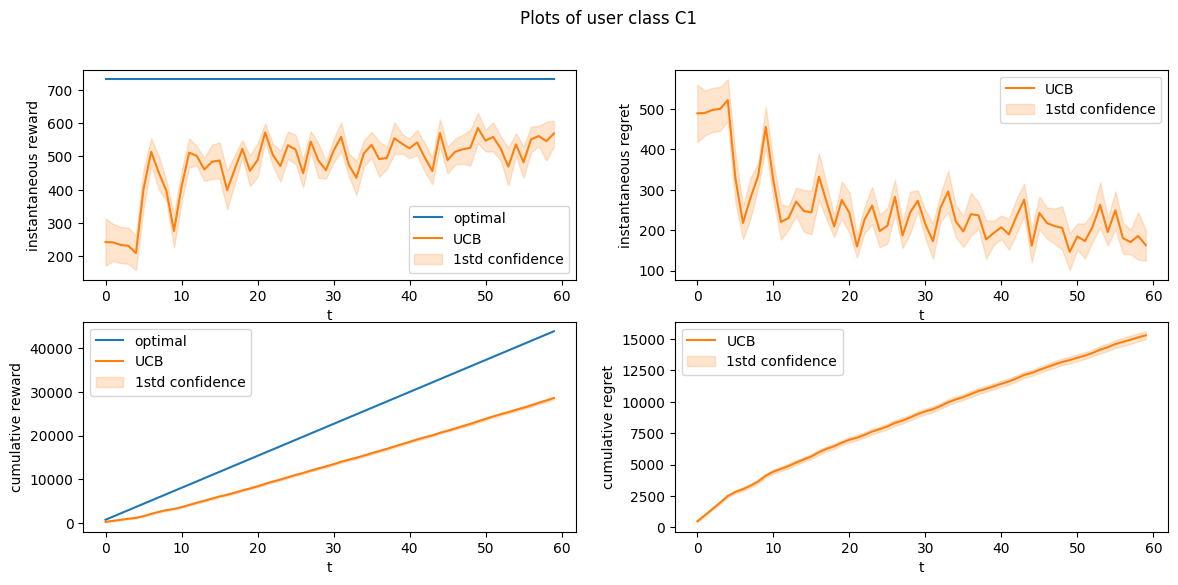

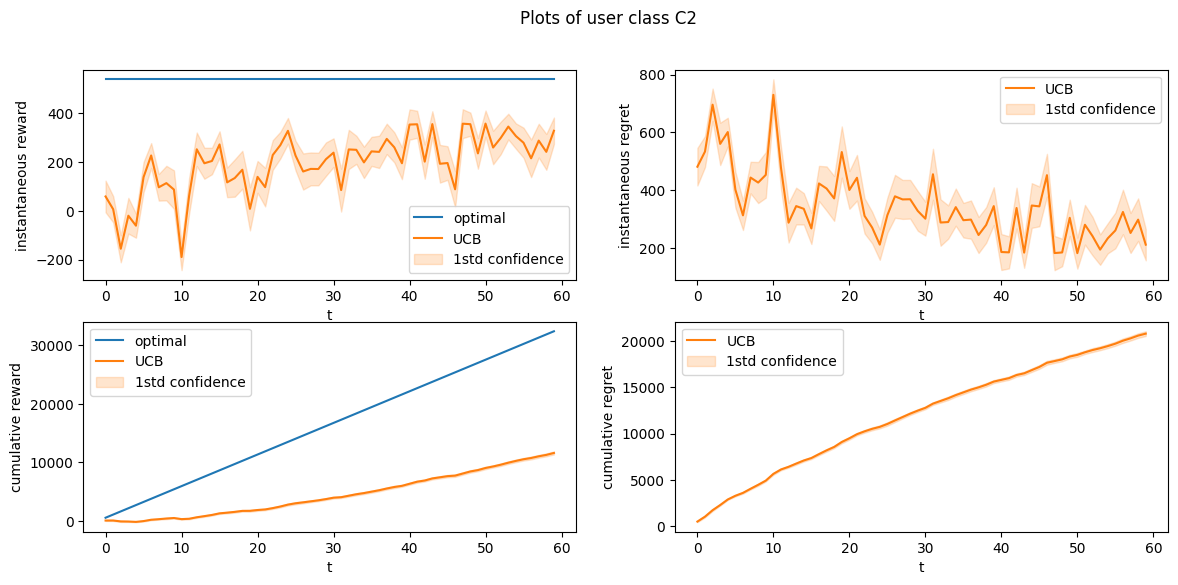

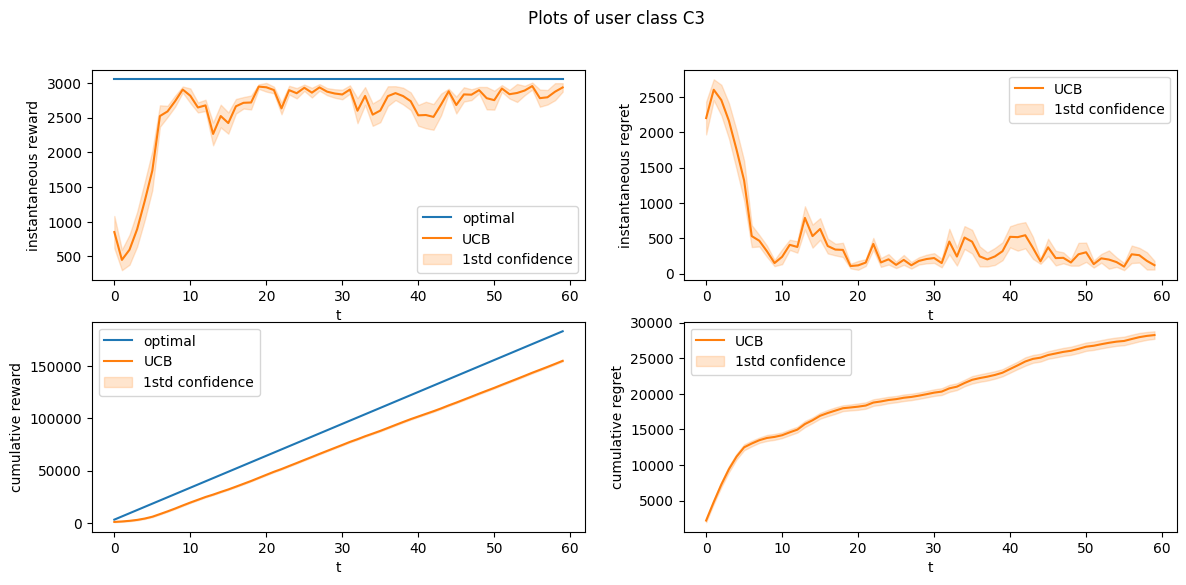

In [18]:
for i in range(3):
    std_inst = np.std(rewards_simulations[:,:,i], axis = 0)/np.sqrt(n_experiments)
    std_cum = np.std(np.cumsum(rewards_simulations[:,:,i], axis = 1), axis = 0)/np.sqrt(n_experiments)

    mean_rewards_hat = np.mean(rewards_simulations[:,:,i], axis = 0)
    opt = opt_list[i]

    #Plots
    plt.figure(figsize = (14,6))
    plt.suptitle(f'Plots of user class C{i+1}')

    plt.subplot(2,2,1)
    plt.xlabel("t")
    plt.ylabel("instantaneous reward")
    plt.plot(np.full(T,opt), label = "optimal")
    plt.plot(mean_rewards_hat, 'C1', label = "UCB")
    plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,2)
    plt.xlabel("t")
    plt.ylabel("instantaneous regret")
    plt.plot(opt - mean_rewards_hat, 'C1', label = "UCB")
    plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,3)
    plt.xlabel("t")
    plt.ylabel("cumulative reward")
    plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
    plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "UCB")
    plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,4)
    plt.xlabel("t")
    plt.ylabel("cumulative regret")
    plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "UCB")
    plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

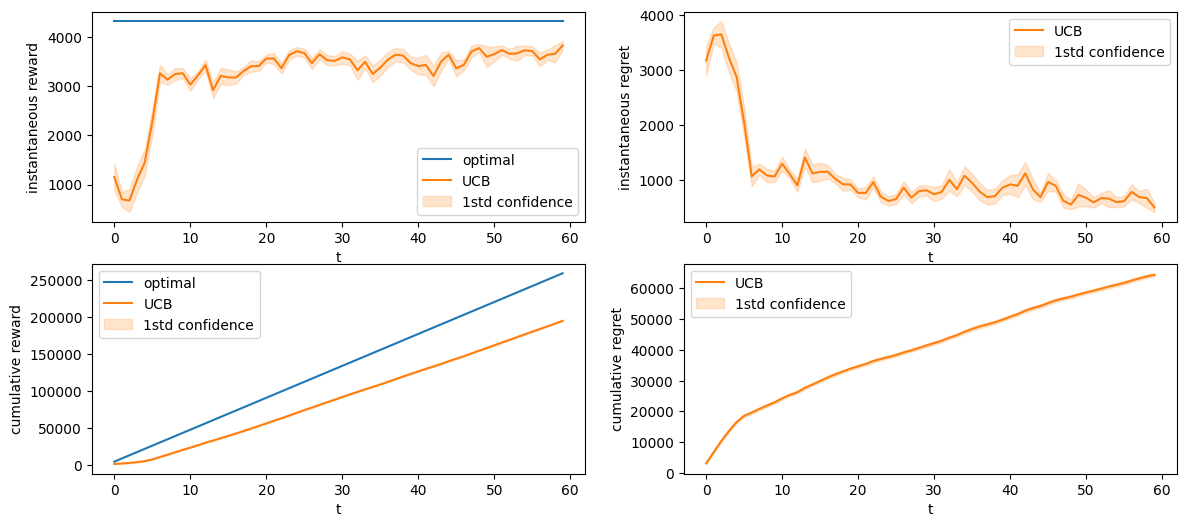

In [19]:
sum_rewards_simulations = np.sum(rewards_simulations, axis = 2)

std_inst = np.std(sum_rewards_simulations, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(sum_rewards_simulations, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(sum_rewards_simulations, axis = 0)
opt = sum(opt_list)


#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "UCB")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

### TS

In [ ]:
## TS learner

ts_rewards_per_experiment = []

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(BIDS, PRICES, SIGMA_CLICKS, SIGMA_COSTS, MARGIN_PARAM, user_classes)
    ts_learner = TS_FixedContextsLearner(BIDS, PRICES, MARGIN_PARAM, real_contexts)

    for t in range(0, T):
        pulled_arm_bid, pulled_arm_price, pulled_contexts = ts_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, converted_clicks, reward, features = env.round(pulled_arm_bid, pulled_arm_price, pulled_contexts)
        ts_learner.update(pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, converted_clicks, reward, features)

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)

Plot

In [22]:
rewards_simulations = np.array(ts_rewards_per_experiment)

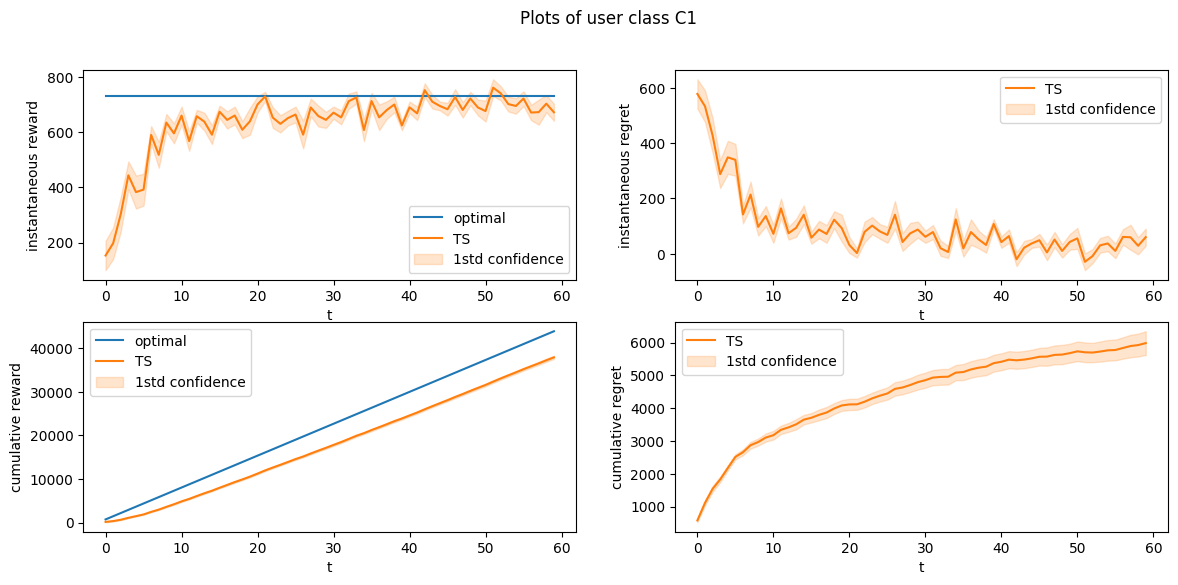

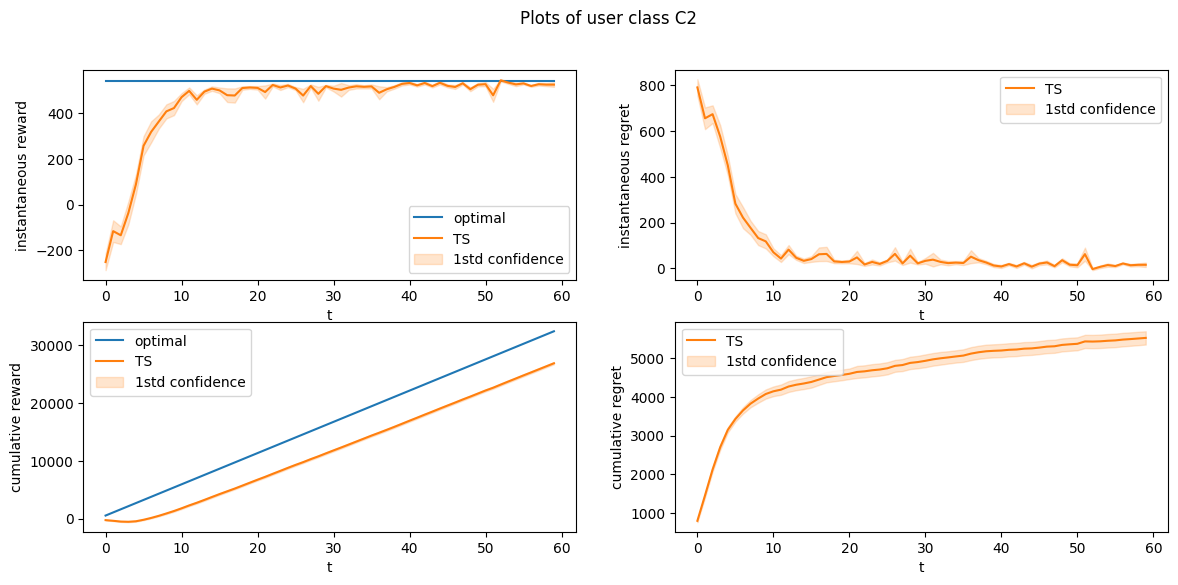

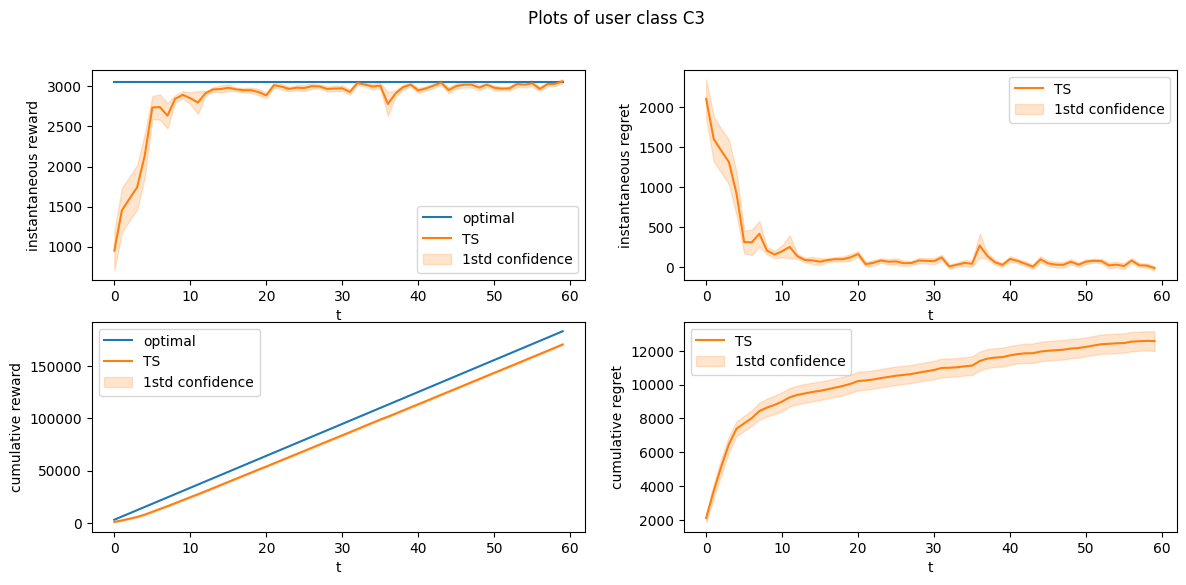

In [23]:
for i in range(3):
    std_inst = np.std(rewards_simulations[:,:,i], axis = 0)/np.sqrt(n_experiments)
    std_cum = np.std(np.cumsum(rewards_simulations[:,:,i], axis = 1), axis = 0)/np.sqrt(n_experiments)

    mean_rewards_hat = np.mean(rewards_simulations[:,:,i], axis = 0)
    opt = opt_list[i]

    #Plots
    plt.figure(figsize = (14,6))
    plt.suptitle(f'Plots of user class C{i+1}')

    plt.subplot(2,2,1)
    plt.xlabel("t")
    plt.ylabel("instantaneous reward")
    plt.plot(np.full(T,opt), label = "optimal")
    plt.plot(mean_rewards_hat, 'C1', label = "TS")
    plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,2)
    plt.xlabel("t")
    plt.ylabel("instantaneous regret")
    plt.plot(opt - mean_rewards_hat, 'C1', label = "TS")
    plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,3)
    plt.xlabel("t")
    plt.ylabel("cumulative reward")
    plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
    plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "TS")
    plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,4)
    plt.xlabel("t")
    plt.ylabel("cumulative regret")
    plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "TS")
    plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

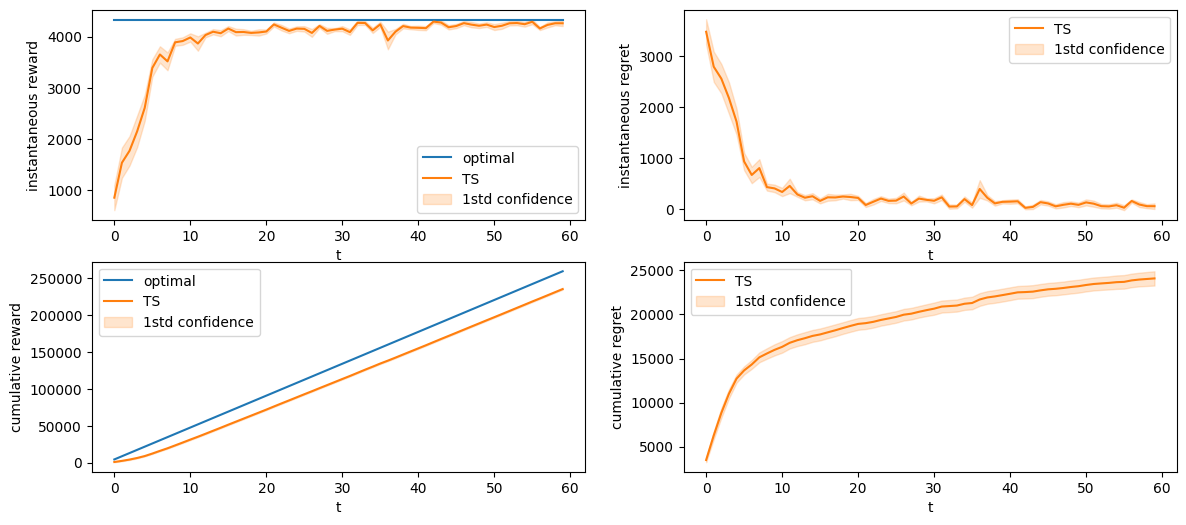

In [24]:
sum_rewards_simulations = np.sum(rewards_simulations, axis = 2)

std_inst = np.std(sum_rewards_simulations, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(sum_rewards_simulations, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(sum_rewards_simulations, axis = 0)
opt = sum(opt_list)


#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "TS")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "TS")
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "TS")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "TS")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

### Plot both UCB and TS

In [27]:
ucb_sum_rewards_per_experiment = np.sum(ucb_rewards_per_experiment, axis = 2)
ts_sum_rewards_per_experiment = np.sum(ts_rewards_per_experiment, axis = 2)

## UCB
ucb_std_inst = np.std(ucb_sum_rewards_per_experiment, axis = 0) / np.sqrt(n_experiments)
ucb_std_cum = np.std(np.cumsum(ucb_sum_rewards_per_experiment, axis = 1), axis = 0) / np.sqrt(n_experiments)

ucb_mean_rewards_hat = np.mean(ucb_sum_rewards_per_experiment, axis = 0)

## TS
ts_std_inst = np.std(ts_sum_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
ts_std_cum = np.std(np.cumsum(ts_sum_rewards_per_experiment, axis = 1), axis = 0) / np.sqrt(n_experiments)

ts_mean_rewards_hat = np.mean(ts_sum_rewards_per_experiment, axis = 0)

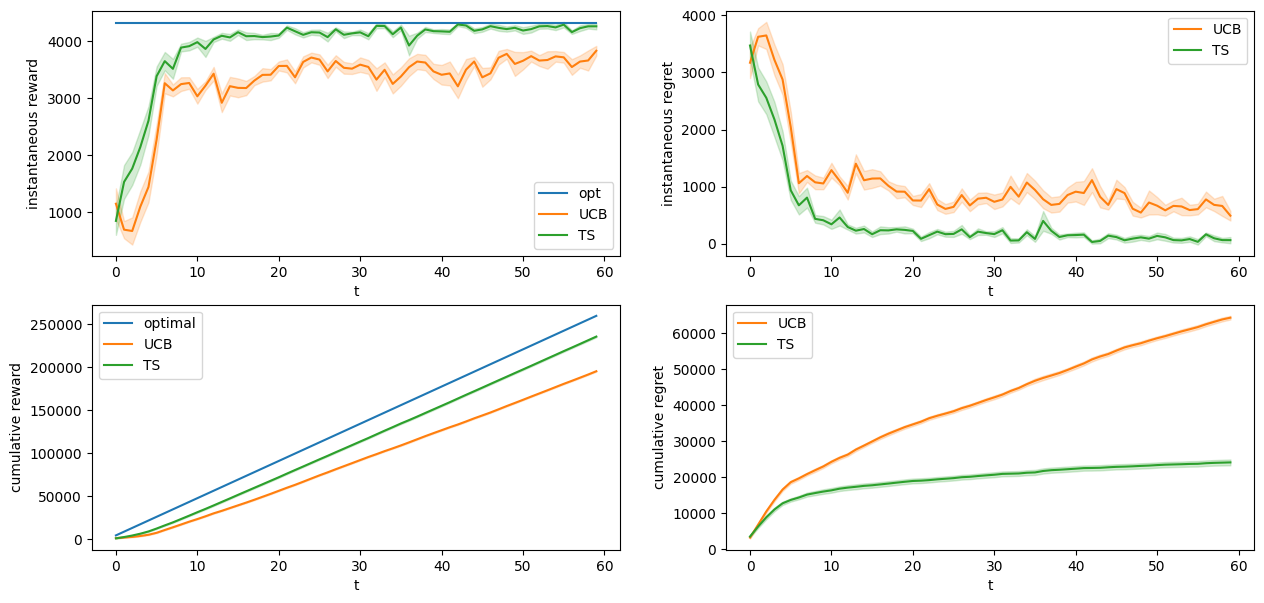

In [28]:
#Starting plots
plt.figure(figsize = (15,7))

#Comparing instantaneous reward
plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "opt")
plt.plot(ucb_mean_rewards_hat, color = 'C1', label = "UCB")
plt.fill_between(np.arange(T), ucb_mean_rewards_hat - ucb_std_inst, ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(ts_mean_rewards_hat, color = 'C2', label = "TS")
plt.fill_between(np.arange(T), ts_mean_rewards_hat-ts_std_inst, ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()

#Comparing instantaneous regret
plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - ucb_mean_rewards_hat, color = "C1", label = "UCB")
plt.fill_between(np.arange(T), opt - ucb_mean_rewards_hat - ucb_std_inst, opt - ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(opt - ts_mean_rewards_hat, color = "C2", label = "TS")
plt.fill_between(np.arange(T), opt - ts_mean_rewards_hat - ts_std_inst, opt - ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()

#Comparing cumulative reward
plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(ucb_mean_rewards_hat), color = "C1", label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(ts_mean_rewards_hat), color = "C2", label = "TS")
plt.fill_between(np.arange(T), np.cumsum(ts_mean_rewards_hat) - ts_std_cum, np.cumsum(ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()

#Comparing cumulative regret
plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - ucb_mean_rewards_hat), color = "C1", label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(opt - ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(opt - ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(opt - ts_mean_rewards_hat), color = "C2", label = "TS")
plt.fill_between(np.arange(T), np.cumsum(opt - ts_mean_rewards_hat) - ts_std_cum, np.cumsum(opt - ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()

## Case: unknown structure & no context generation

### UCB

In [ ]:
## UCB learner

ucb_rewards_per_experiment = []

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(BIDS, PRICES, SIGMA_CLICKS, SIGMA_COSTS, MARGIN_PARAM, user_classes)
    ucb_learner = UCB_FixedContextsLearner(BIDS, PRICES, MARGIN_PARAM, [ [(0,0),(0,1),(1,0),(1,1)] ], M)

    for t in range(0, T):
        pulled_arm_bid, pulled_arm_price, pulled_contexts = ucb_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, converted_clicks, reward, features = env.round(pulled_arm_bid, pulled_arm_price, pulled_contexts)
        ucb_learner.update(pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, converted_clicks, reward, features)

    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)

Plot

In [31]:
rewards_simulations = np.array(ucb_rewards_per_experiment)

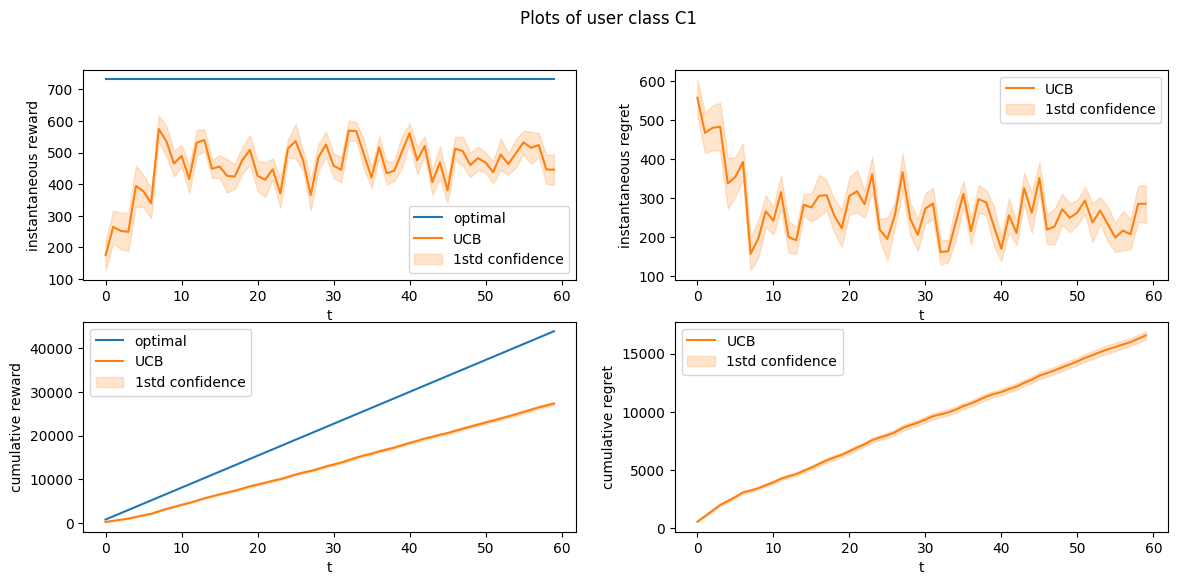

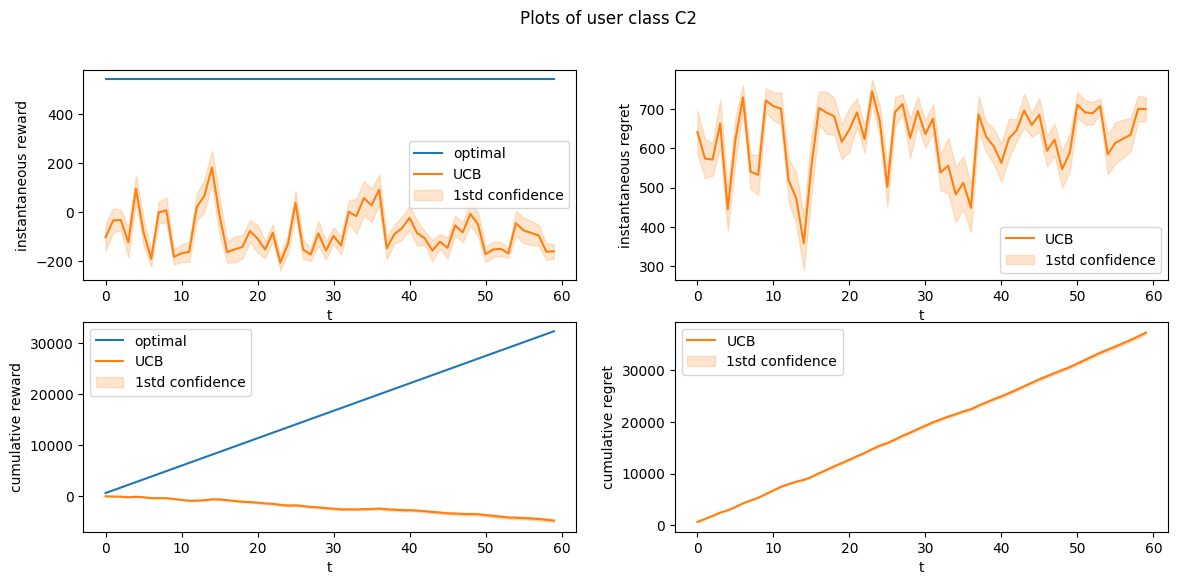

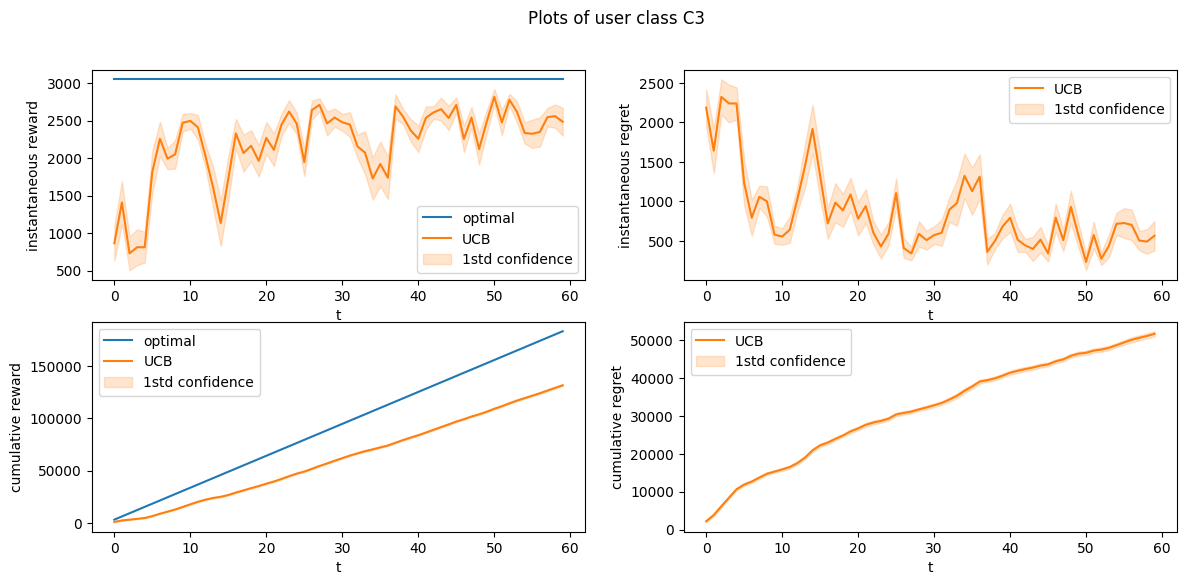

In [ ]:
for i in range(3):
    std_inst = np.std(rewards_simulations[:,:,i], axis = 0)/np.sqrt(n_experiments)
    std_cum = np.std(np.cumsum(rewards_simulations[:,:,i], axis = 1), axis = 0)/np.sqrt(n_experiments)

    mean_rewards_hat = np.mean(rewards_simulations[:,:,i], axis = 0)
    opt = opt_list[i]

    #Plots
    plt.figure(figsize = (14,6))
    plt.suptitle(f'Plots of user class C{i+1}')

    plt.subplot(2,2,1)
    plt.xlabel("t")
    plt.ylabel("instantaneous reward")
    plt.plot(np.full(T,opt), label = "optimal")
    plt.plot(mean_rewards_hat, 'C1', label = "UCB")
    plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,2)
    plt.xlabel("t")
    plt.ylabel("instantaneous regret")
    plt.plot(opt - mean_rewards_hat, 'C1', label = "UCB")
    plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,3)
    plt.xlabel("t")
    plt.ylabel("cumulative reward")
    plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
    plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "UCB")
    plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,4)
    plt.xlabel("t")
    plt.ylabel("cumulative regret")
    plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "UCB")
    plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

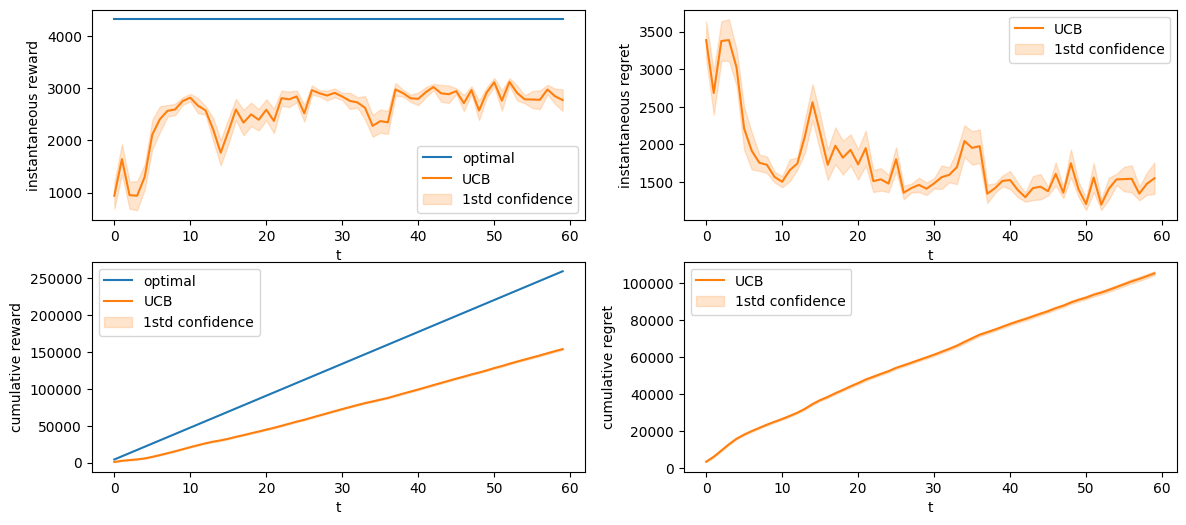

In [ ]:
sum_rewards_simulations = np.sum(rewards_simulations, axis = 2)

std_inst = np.std(sum_rewards_simulations, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(sum_rewards_simulations, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(sum_rewards_simulations, axis = 0)
opt = sum(opt_list)


#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "UCB")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

### TS

In [ ]:
## TS learner

ts_rewards_per_experiment = []

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(BIDS, PRICES, SIGMA_CLICKS, SIGMA_COSTS, MARGIN_PARAM, user_classes)
    ts_learner = TS_FixedContextsLearner(BIDS, PRICES, MARGIN_PARAM, [ [(0,0),(0,1),(1,0),(1,1)] ])

    for t in range(0, T):
        pulled_arm_bid, pulled_arm_price, pulled_contexts = ts_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, converted_clicks, reward, features = env.round(pulled_arm_bid, pulled_arm_price, pulled_contexts)
        ts_learner.update(pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, converted_clicks, reward, features)

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)

Plot

In [36]:
rewards_simulations = np.array(ts_rewards_per_experiment)

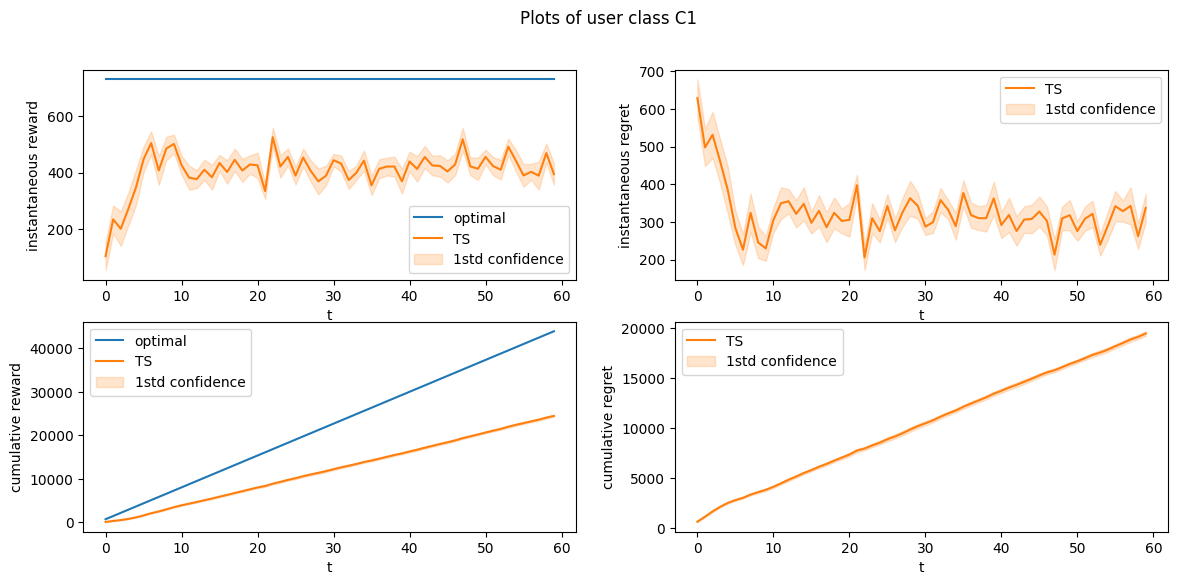

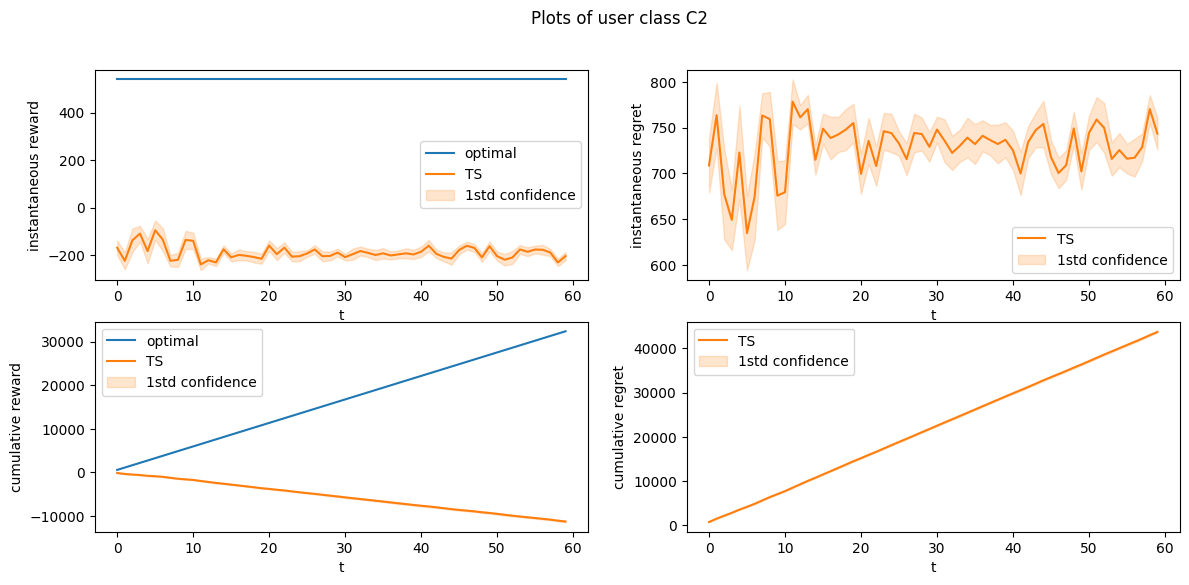

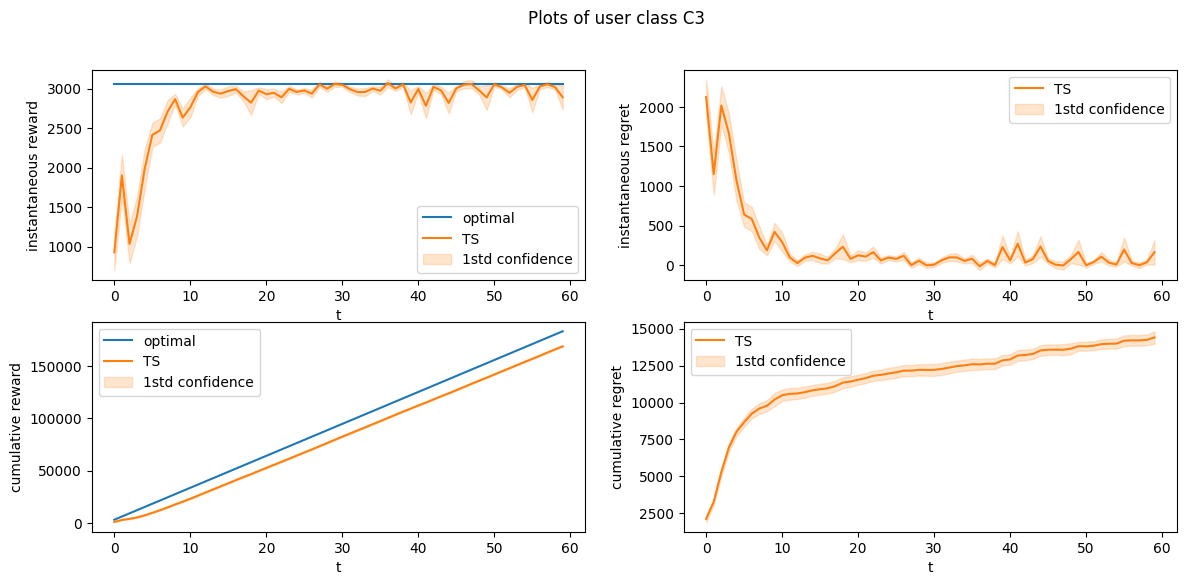

In [ ]:
for i in range(3):
    std_inst = np.std(rewards_simulations[:,:,i], axis = 0)/np.sqrt(n_experiments)
    std_cum = np.std(np.cumsum(rewards_simulations[:,:,i], axis = 1), axis = 0)/np.sqrt(n_experiments)

    mean_rewards_hat = np.mean(rewards_simulations[:,:,i], axis = 0)
    opt = opt_list[i]

    #Plots
    plt.figure(figsize = (14,6))
    plt.suptitle(f'Plots of user class C{i+1}')

    plt.subplot(2,2,1)
    plt.xlabel("t")
    plt.ylabel("instantaneous reward")
    plt.plot(np.full(T,opt), label = "optimal")
    plt.plot(mean_rewards_hat, 'C1', label = "TS")
    plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,2)
    plt.xlabel("t")
    plt.ylabel("instantaneous regret")
    plt.plot(opt - mean_rewards_hat, 'C1', label = "TS")
    plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,3)
    plt.xlabel("t")
    plt.ylabel("cumulative reward")
    plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
    plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "TS")
    plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,4)
    plt.xlabel("t")
    plt.ylabel("cumulative regret")
    plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "TS")
    plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

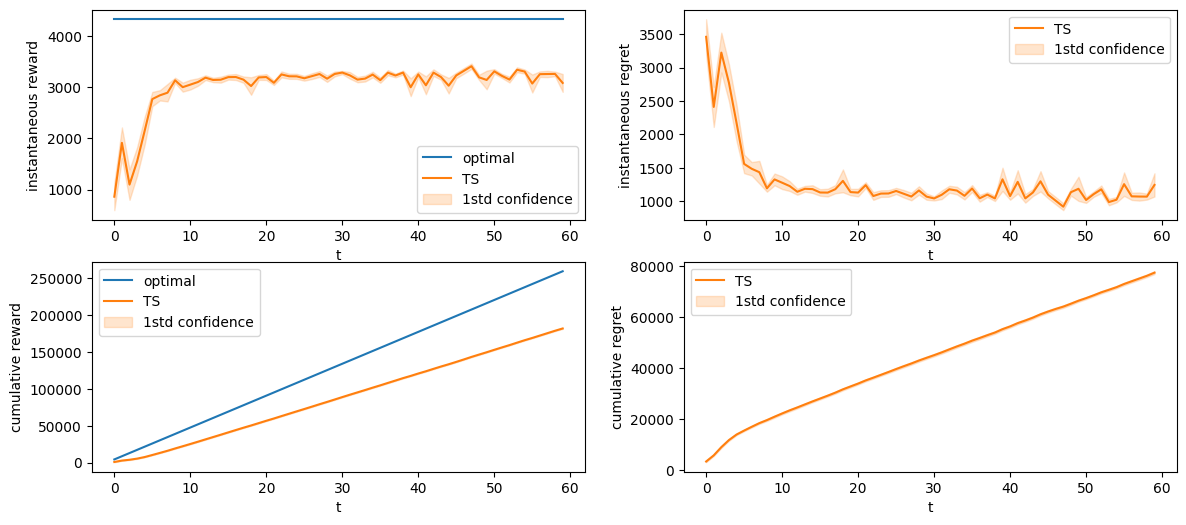

In [ ]:
sum_rewards_simulations = np.sum(rewards_simulations, axis = 2)

std_inst = np.std(sum_rewards_simulations, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(sum_rewards_simulations, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(sum_rewards_simulations, axis = 0)
opt = sum(opt_list)


#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "TS")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "TS")
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "TS")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "TS")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

### Plot both UCB and TS

In [39]:
## UCB
ucb_sum_rewards_per_experiment = np.sum(ucb_rewards_per_experiment, axis = 2)
ts_sum_rewards_per_experiment = np.sum(ts_rewards_per_experiment, axis = 2)

## UCB
ucb_std_inst = np.std(ucb_sum_rewards_per_experiment, axis = 0) / np.sqrt(n_experiments)
ucb_std_cum = np.std(np.cumsum(ucb_sum_rewards_per_experiment, axis = 1), axis = 0) / np.sqrt(n_experiments)

ucb_mean_rewards_hat = np.mean(ucb_sum_rewards_per_experiment, axis = 0)

## TS
ts_std_inst = np.std(ts_sum_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
ts_std_cum = np.std(np.cumsum(ts_sum_rewards_per_experiment, axis = 1), axis = 0) / np.sqrt(n_experiments)

ts_mean_rewards_hat = np.mean(ts_sum_rewards_per_experiment, axis = 0)

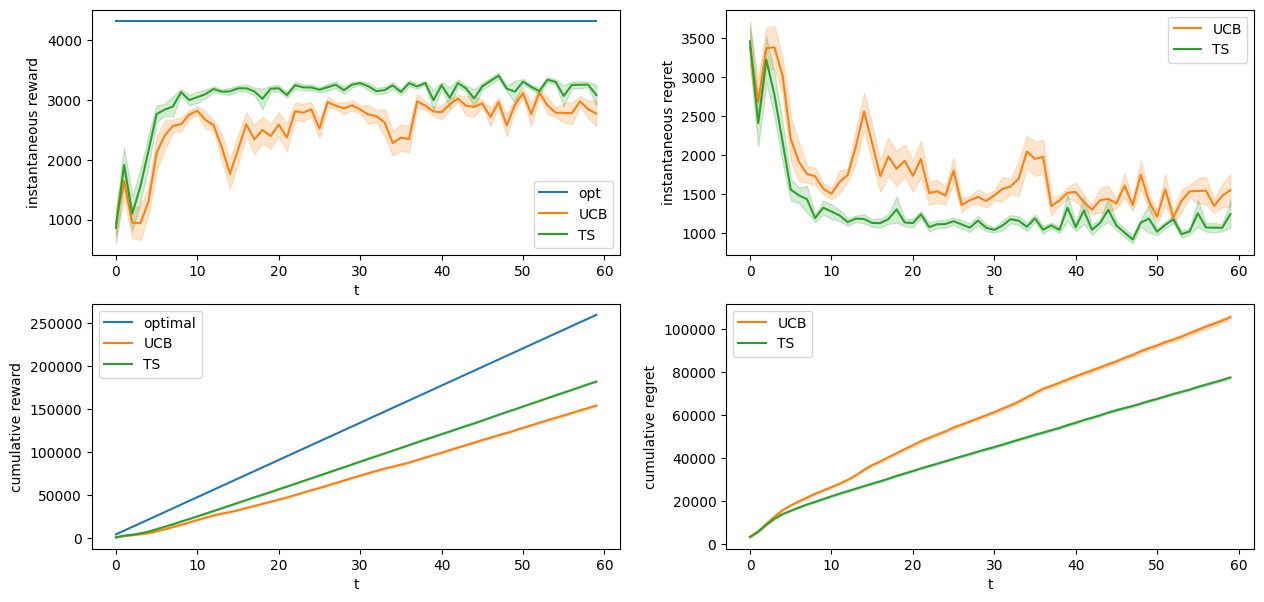

In [ ]:
#Starting plots
plt.figure(figsize = (15,7))

#Comparing instantaneous reward
plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "opt")
plt.plot(ucb_mean_rewards_hat, color = 'C1', label = "UCB")
plt.fill_between(np.arange(T), ucb_mean_rewards_hat - ucb_std_inst, ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(ts_mean_rewards_hat, color = 'C2', label = "TS")
plt.fill_between(np.arange(T), ts_mean_rewards_hat-ts_std_inst, ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()

#Comparing instantaneous regret
plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - ucb_mean_rewards_hat, color = "C1", label = "UCB")
plt.fill_between(np.arange(T), opt - ucb_mean_rewards_hat - ucb_std_inst, opt - ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(opt - ts_mean_rewards_hat, color = "C2", label = "TS")
plt.fill_between(np.arange(T), opt - ts_mean_rewards_hat - ts_std_inst, opt - ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()

#Comparing cumulative reward
plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(ucb_mean_rewards_hat), color = "C1", label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(ts_mean_rewards_hat), color = "C2", label = "TS")
plt.fill_between(np.arange(T), np.cumsum(ts_mean_rewards_hat) - ts_std_cum, np.cumsum(ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()

#Comparing cumulative regret
plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - ucb_mean_rewards_hat), color = "C1", label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(opt - ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(opt - ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(opt - ts_mean_rewards_hat), color = "C2", label = "TS")
plt.fill_between(np.arange(T), np.cumsum(opt - ts_mean_rewards_hat) - ts_std_cum, np.cumsum(opt - ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()

## Case: unknown structure & with context generation

### UCB

In [ ]:
## UCB learner

ucb_rewards_per_experiment = []

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(BIDS, PRICES, SIGMA_CLICKS, SIGMA_COSTS, MARGIN_PARAM, user_classes)
    ucb_learner = UCB_ContextsGreadyLearner(BIDS, PRICES, MARGIN_PARAM, window_context, M)

    for t in range(0, T):
        pulled_arm_bid, pulled_arm_price, pulled_contexts = ucb_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, converted_clicks, reward, features = env.round(pulled_arm_bid, pulled_arm_price, pulled_contexts)
        ucb_learner.update(pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, converted_clicks, reward, features)

    ucb_rewards_per_experiment.append(ucb_learner.collected_rewards)

Plot

In [43]:
rewards_simulations = np.array(ucb_rewards_per_experiment)

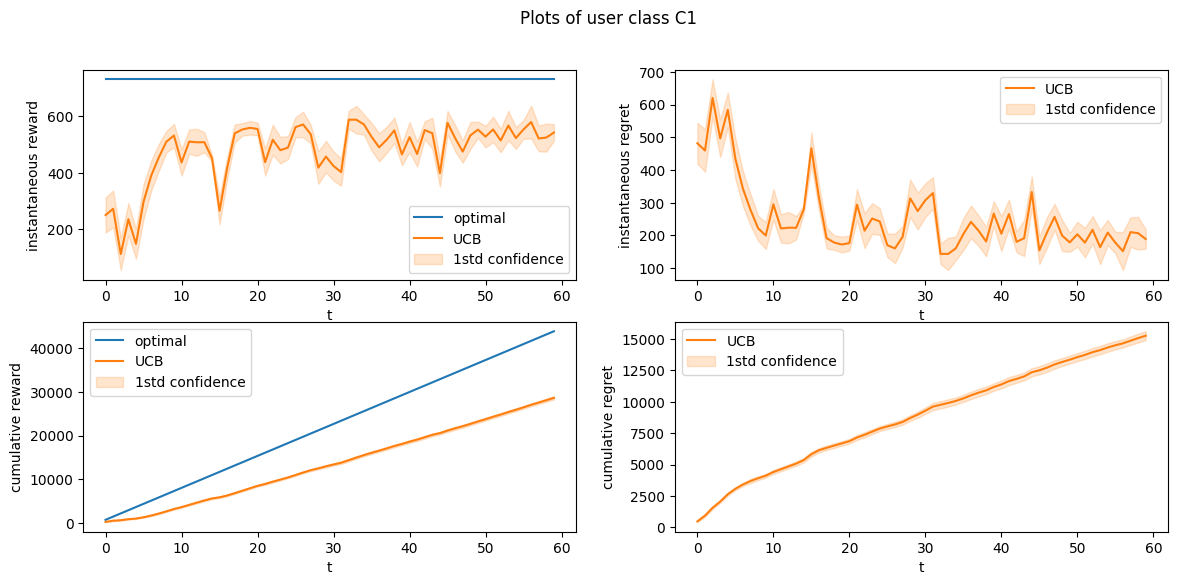

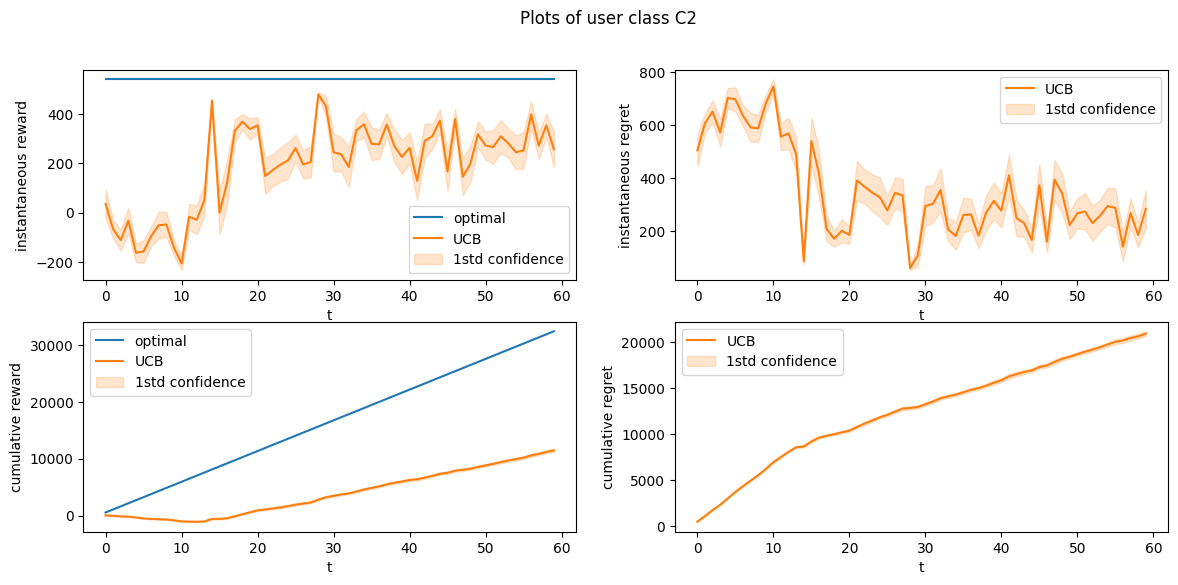

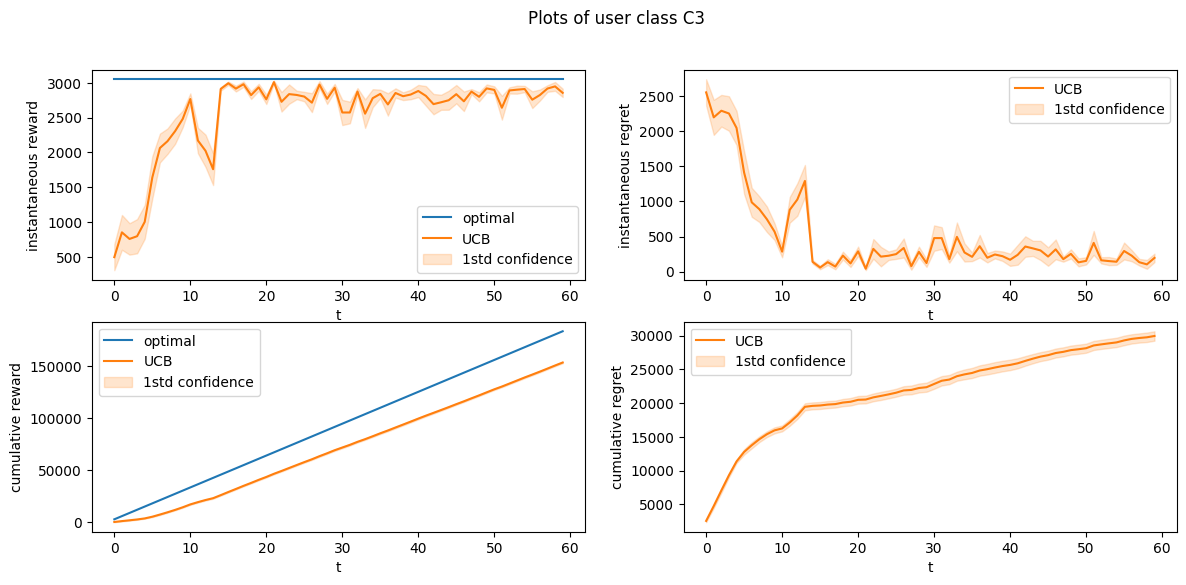

In [44]:
for i in range(3):
    std_inst = np.std(rewards_simulations[:,:,i], axis = 0)/np.sqrt(n_experiments)
    std_cum = np.std(np.cumsum(rewards_simulations[:,:,i], axis = 1), axis = 0)/np.sqrt(n_experiments)

    mean_rewards_hat = np.mean(rewards_simulations[:,:,i], axis = 0)
    opt = opt_list[i]

    #Plots
    plt.figure(figsize = (14,6))
    plt.suptitle(f'Plots of user class C{i+1}')

    plt.subplot(2,2,1)
    plt.xlabel("t")
    plt.ylabel("instantaneous reward")
    plt.plot(np.full(T,opt), label = "optimal")
    plt.plot(mean_rewards_hat, 'C1', label = "UCB")
    plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,2)
    plt.xlabel("t")
    plt.ylabel("instantaneous regret")
    plt.plot(opt - mean_rewards_hat, 'C1', label = "UCB")
    plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,3)
    plt.xlabel("t")
    plt.ylabel("cumulative reward")
    plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
    plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "UCB")
    plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,4)
    plt.xlabel("t")
    plt.ylabel("cumulative regret")
    plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "UCB")
    plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

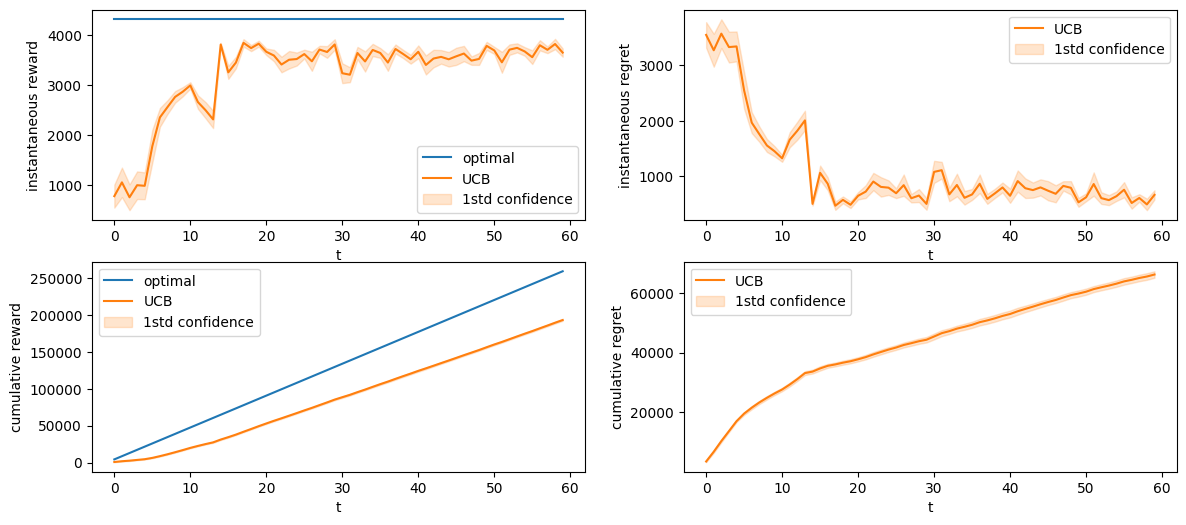

In [45]:
sum_rewards_simulations = np.sum(rewards_simulations, axis = 2)

std_inst = np.std(sum_rewards_simulations, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(sum_rewards_simulations, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(sum_rewards_simulations, axis = 0)
opt = sum(opt_list)


#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "UCB")
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "UCB")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

### TS

In [ ]:
## TS learner

ts_rewards_per_experiment = []

for e in range(0, n_experiments):
    print(f'{e/n_experiments*100}%')

    env = Environment(BIDS, PRICES, SIGMA_CLICKS, SIGMA_COSTS, MARGIN_PARAM, user_classes)
    ts_learner = TS_ContextsGreedyLearner(BIDS, PRICES, MARGIN_PARAM, window_context)

    for t in range(0, T):
        pulled_arm_bid, pulled_arm_price, pulled_contexts = ts_learner.pull_arm()
        n_daily_clicks, cum_daily_costs, converted_clicks, reward, features = env.round(pulled_arm_bid, pulled_arm_price, pulled_contexts)
        ts_learner.update(pulled_arm_bid, pulled_arm_price, n_daily_clicks, cum_daily_costs, converted_clicks, reward, features)

    ts_rewards_per_experiment.append(ts_learner.collected_rewards)

Plot

In [48]:
rewards_simulations = np.array(ts_rewards_per_experiment)

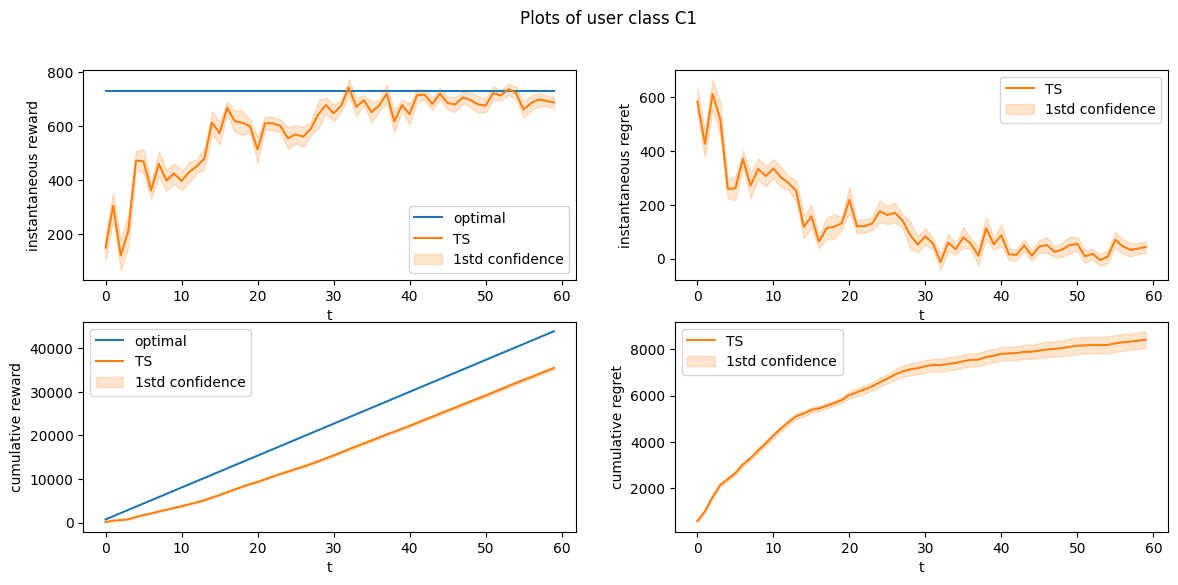

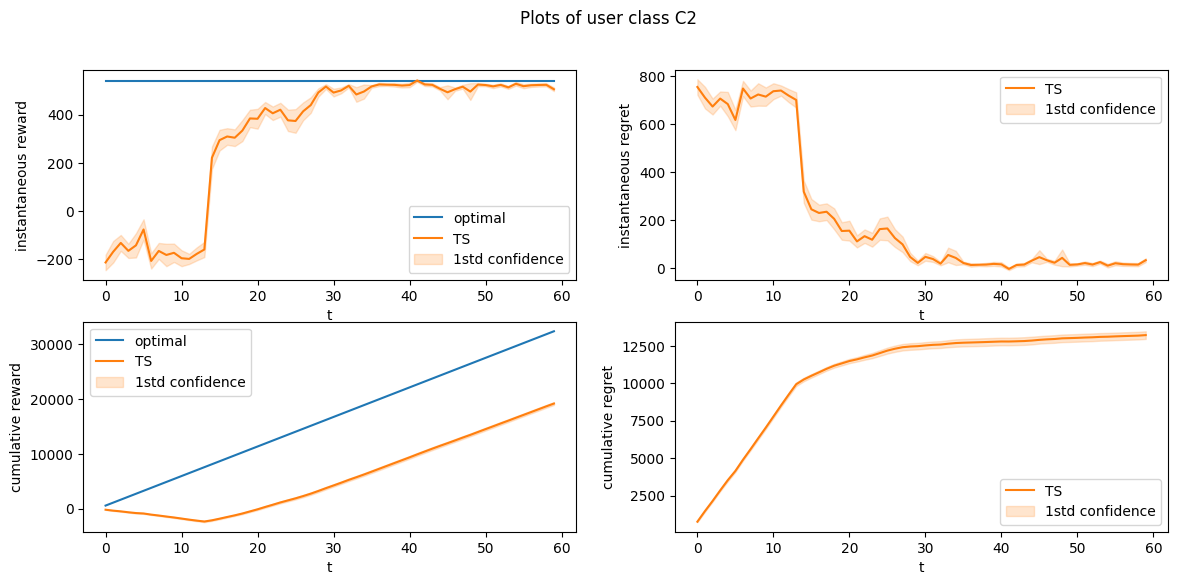

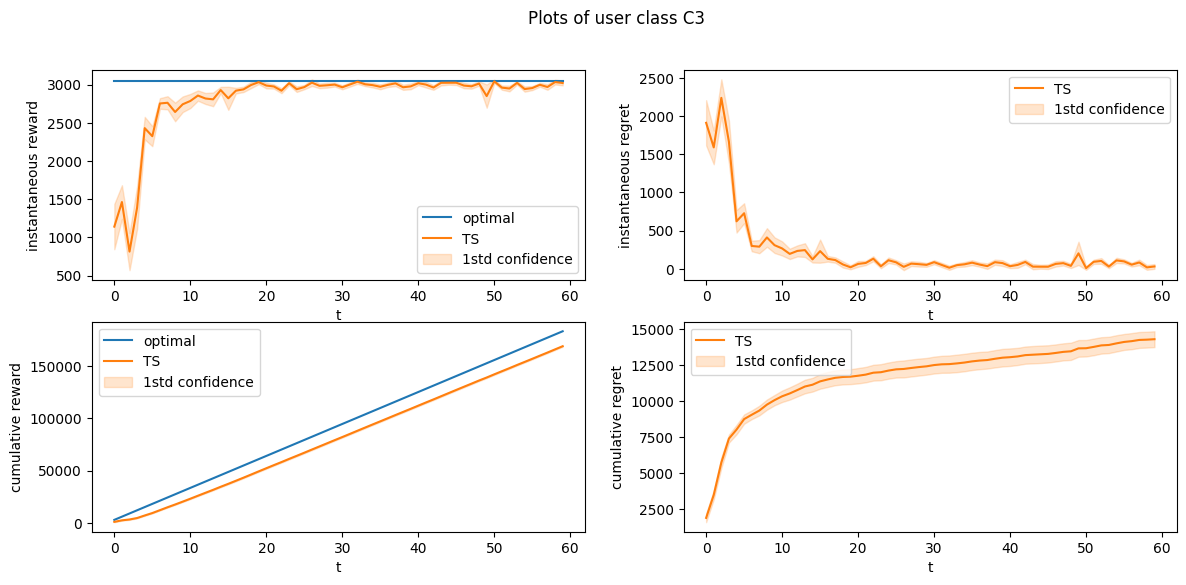

In [49]:
for i in range(3):
    std_inst = np.std(rewards_simulations[:,:,i], axis = 0)/np.sqrt(n_experiments)
    std_cum = np.std(np.cumsum(rewards_simulations[:,:,i], axis = 1), axis = 0)/np.sqrt(n_experiments)

    mean_rewards_hat = np.mean(rewards_simulations[:,:,i], axis = 0)
    opt = opt_list[i]

    #Plots
    plt.figure(figsize = (14,6))
    plt.suptitle(f'Plots of user class C{i+1}')

    plt.subplot(2,2,1)
    plt.xlabel("t")
    plt.ylabel("instantaneous reward")
    plt.plot(np.full(T,opt), label = "optimal")
    plt.plot(mean_rewards_hat, 'C1', label = "TS")
    plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,2)
    plt.xlabel("t")
    plt.ylabel("instantaneous regret")
    plt.plot(opt - mean_rewards_hat, 'C1', label = "TS")
    plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,3)
    plt.xlabel("t")
    plt.ylabel("cumulative reward")
    plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
    plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "TS")
    plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

    plt.subplot(2,2,4)
    plt.xlabel("t")
    plt.ylabel("cumulative regret")
    plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "TS")
    plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
    plt.legend()

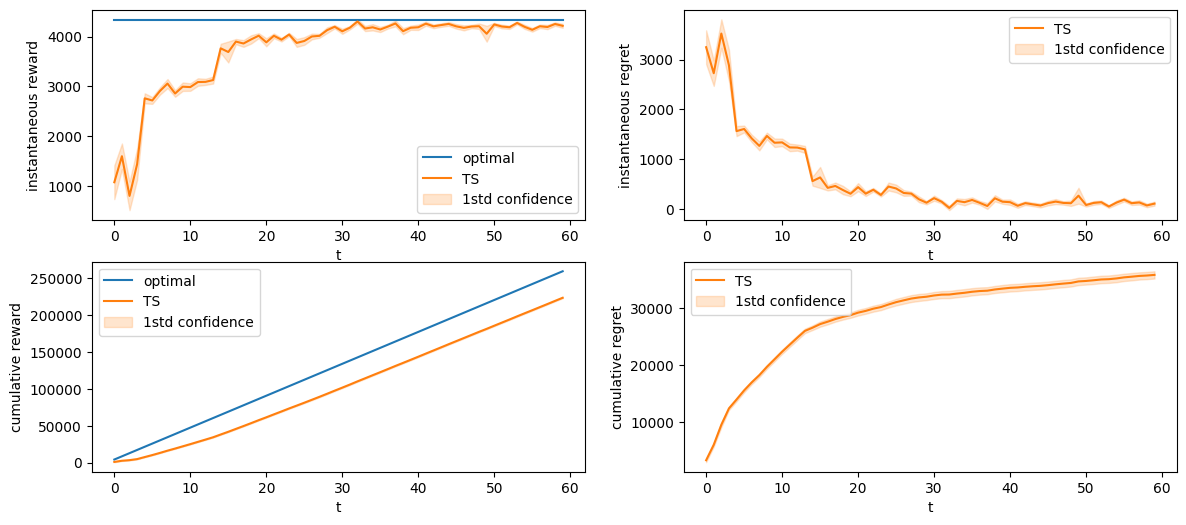

In [50]:
sum_rewards_simulations = np.sum(rewards_simulations, axis = 2)

std_inst = np.std(sum_rewards_simulations, axis = 0)/np.sqrt(n_experiments)
std_cum = np.std(np.cumsum(sum_rewards_simulations, axis = 1), axis = 0)/np.sqrt(n_experiments)

mean_rewards_hat = np.mean(sum_rewards_simulations, axis = 0)
opt = sum(opt_list)


#Plots
plt.figure(figsize = (14,6))

plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "optimal")
plt.plot(mean_rewards_hat, 'C1', label = "TS")
plt.fill_between(np.arange(T), mean_rewards_hat-std_inst, mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - mean_rewards_hat, 'C1', label = "TS")
plt.fill_between(np.arange(T), opt - mean_rewards_hat -std_inst, opt - mean_rewards_hat + std_inst, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()



plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(mean_rewards_hat), 'C1', label = "TS")
plt.fill_between(np.arange(T), np.cumsum(mean_rewards_hat)-std_cum, np.cumsum(mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - mean_rewards_hat), 'C1', label = "TS")
plt.fill_between(np.arange(T),np.cumsum(opt - mean_rewards_hat)-std_cum, np.cumsum(opt - mean_rewards_hat) + std_cum, alpha = 0.2, color = 'C1', label = "1std confidence")
plt.legend()

### Plot both UCB and TS

In [51]:
ucb_sum_rewards_per_experiment = np.sum(ucb_rewards_per_experiment, axis = 2)
ts_sum_rewards_per_experiment = np.sum(ts_rewards_per_experiment, axis = 2)

## UCB
ucb_std_inst = np.std(ucb_sum_rewards_per_experiment, axis = 0) / np.sqrt(n_experiments)
ucb_std_cum = np.std(np.cumsum(ucb_sum_rewards_per_experiment, axis = 1), axis = 0) / np.sqrt(n_experiments)

ucb_mean_rewards_hat = np.mean(ucb_sum_rewards_per_experiment, axis = 0)

## TS
ts_std_inst = np.std(ts_sum_rewards_per_experiment, axis = 0)/np.sqrt(n_experiments)
ts_std_cum = np.std(np.cumsum(ts_sum_rewards_per_experiment, axis = 1), axis = 0) / np.sqrt(n_experiments)

ts_mean_rewards_hat = np.mean(ts_sum_rewards_per_experiment, axis = 0)

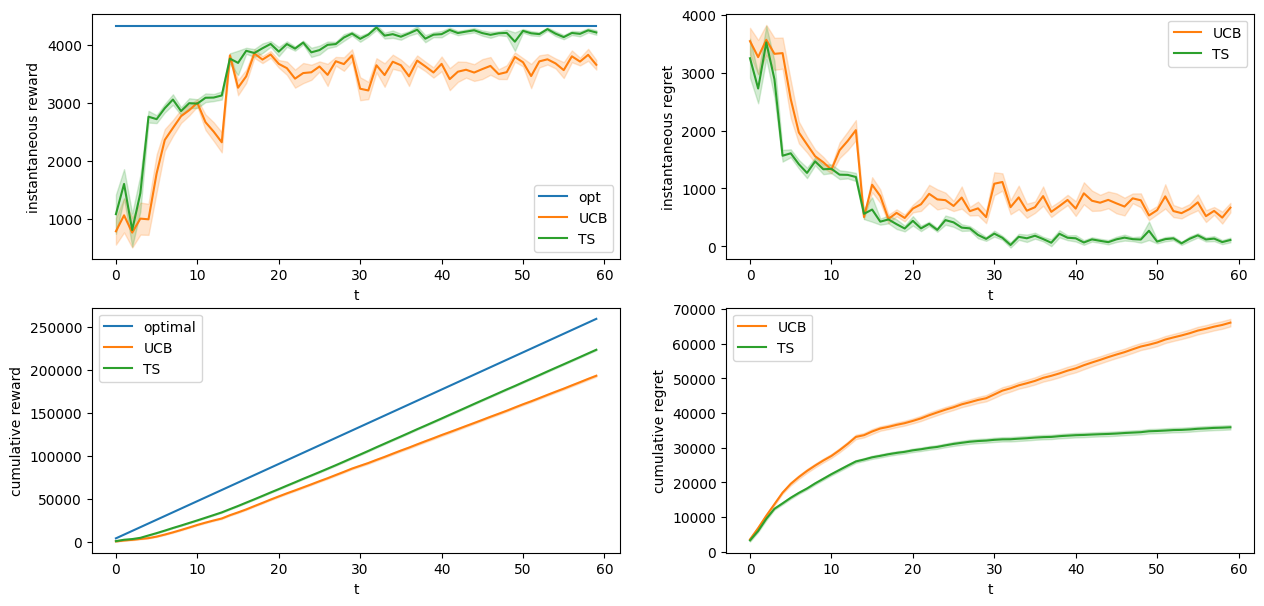

In [52]:
#Starting plots
plt.figure(figsize = (15,7))

#Comparing instantaneous reward
plt.subplot(2,2,1)
plt.xlabel("t")
plt.ylabel("instantaneous reward")
plt.plot(np.full(T,opt), label = "opt")
plt.plot(ucb_mean_rewards_hat, color = 'C1', label = "UCB")
plt.fill_between(np.arange(T), ucb_mean_rewards_hat - ucb_std_inst, ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(ts_mean_rewards_hat, color = 'C2', label = "TS")
plt.fill_between(np.arange(T), ts_mean_rewards_hat-ts_std_inst, ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()

#Comparing instantaneous regret
plt.subplot(2,2,2)
plt.xlabel("t")
plt.ylabel("instantaneous regret")
plt.plot(opt - ucb_mean_rewards_hat, color = "C1", label = "UCB")
plt.fill_between(np.arange(T), opt - ucb_mean_rewards_hat - ucb_std_inst, opt - ucb_mean_rewards_hat + ucb_std_inst, alpha = 0.2, color = 'C1')
plt.plot(opt - ts_mean_rewards_hat, color = "C2", label = "TS")
plt.fill_between(np.arange(T), opt - ts_mean_rewards_hat - ts_std_inst, opt - ts_mean_rewards_hat + ts_std_inst, alpha = 0.2, color = 'C2')
plt.legend()

#Comparing cumulative reward
plt.subplot(2,2,3)
plt.xlabel("t")
plt.ylabel("cumulative reward")
plt.plot(np.cumsum(np.full(T,opt)), label = "optimal")
plt.plot(np.cumsum(ucb_mean_rewards_hat), color = "C1", label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(ts_mean_rewards_hat), color = "C2", label = "TS")
plt.fill_between(np.arange(T), np.cumsum(ts_mean_rewards_hat) - ts_std_cum, np.cumsum(ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()

#Comparing cumulative regret
plt.subplot(2,2,4)
plt.xlabel("t")
plt.ylabel("cumulative regret")
plt.plot(np.cumsum(opt - ucb_mean_rewards_hat), color = "C1", label = "UCB")
plt.fill_between(np.arange(T), np.cumsum(opt - ucb_mean_rewards_hat) - ucb_std_cum, np.cumsum(opt - ucb_mean_rewards_hat) + ucb_std_cum, alpha = 0.2, color = 'C1')
plt.plot(np.cumsum(opt - ts_mean_rewards_hat), color = "C2", label = "TS")
plt.fill_between(np.arange(T), np.cumsum(opt - ts_mean_rewards_hat) - ts_std_cum, np.cumsum(opt - ts_mean_rewards_hat) + ts_std_cum, alpha = 0.2, color = 'C2')
plt.legend()